# Components

```{glue:figure} NTR_components_stds
:scale: 50%
:align: right
```

In this notebook we'll explore the various contributions to high and low water levels. At the moment this is exploratory - we are using this to take broad stroke looks. We'll do this by breaking down the time series of hourly water levels at a tide gauge into different frequency bands, with the idea that certain processes fall within these timescales. For example, we know that ENSO timescales are roughly 4-7 years. We know that PDO timescales are closer to 20 years, and the timescale of mesoscale eddies the Hawaiian Island archipelago are 3 - 6 months. It's important to keep in mind that in this analysis we are not directly relating any of these processes to the observed sea levels at the tide gauges, but rather we are looking at _variability on similar timescales_. 

Thus, we're breaking sea level down into:

$\eta = \eta_{tide} + \eta_{t_N} + \eta_{NTR}$

where

$\eta_{NTR} = \eta_{D} + \eta_{S} + \eta_{ItA} + \eta_{InA} + \eta_{W} + \eta_{HF}$

Note that $\eta_{tide}$ here is accounting for the nodal cycle modulation, and thus it is absent from the non-tidal residuals.

<!-- # make a dictionary of the timescales and the processes
timeframes = {'Decadal': 'e.g. PDO, 8-30+ yr', 
              'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-8 yr', 
              'Intraannual': 'e.g. Mesoscale eddies', 
              'Weekly': '1 week - 2 months', 
              'Storms': '& other short-term variability',
              'Nodal': '18.6 yr tidal modulation'} -->


```{caution}
THIS IS VERY MUCH a work in progress and there are bound to be myriad errors. In particular, the seasonal cycle needs to be treated as an annual cycle (that does not vary year to year).
```

## Setup

In [76]:
print('Importing libraries')
%run setup.ipynb
print('Importing plotting rules and functions')
import plotting_functions
print('Importing time series functions')
from tseries_functions import *
from tide_functions import calculate_ntr

Importing libraries
Importing plotting rules and functions
Importing time series functions


## Obtain the Non-tidal Residual (NTR)

First we'll estimate the astronomical tides at this location using the selected epoch.

In [77]:
ds = xr.open_dataset(data_dir / 'rsl_pacific.nc')

# get the ntr for each station
calculate_ntr(ds)

Already processed 13 files:
[50, 52, 57, 25, 547, 552, 38, 548, 14, 58, 59, 61, 60]


In [78]:
# load ntr data
station = 25
print('Doing station', station)
station_name = ds.station_name.sel(record_id=station).item()
print('Station name:', station_name)
mhhw = ds.MHHW.sel(record_id=station).item()
mllw = ds.MLLW.sel(record_id=station).item()
msl = ds.MSL.sel(record_id=station).item()
ntrpath = f'ntr_data/ntr_{station:03d}.csv'


ntr_data = pd.read_csv(Path(data_dir / ntrpath), parse_dates=['time'])

#inspect it, does it look sane?
ntr_data

Doing station 25
Station name: Funafuti


,time,ntr,sea_level,sea_level_detrended,trend,tide,nodal,ntr_withNodal,seasonal_cycle
0,1993-03-24 01:00:00,-48.300066,1455.0,-595.32660,2014.163568,-547.026533,-12.566312,-102.565316,73.341527
1,1993-03-24 02:00:00,13.983822,1850.0,-200.32658,2014.163568,-214.310406,-13.683600,-39.148672,73.326059
2,1993-03-24 03:00:00,-29.368308,2193.0,142.67342,2014.163568,172.041724,-9.242565,-86.926312,73.310534
3,1993-03-24 04:00:00,-2.480913,2560.0,509.67343,2014.163568,512.154345,0.437328,-69.703228,73.294952
4,1993-03-24 05:00:00,-23.957869,2744.0,693.67340,2014.163568,717.631270,12.846238,-103.573455,73.279313
...,...,...,...,...,...,...,...,...,...
279282,2025-01-31 19:00:00,112.237675,2970.0,919.67340,2087.602358,807.435726,11.534960,53.002703,54.209977
279283,2025-01-31 20:00:00,135.169370,2848.0,797.67340,2087.602358,662.504031,3.511200,83.919690,54.248446
279284,2025-01-31 21:00:00,123.068119,2517.0,466.67343,2087.602358,343.605312,-4.133467,79.424656,54.286895
279285,2025-01-31 22:00:00,178.821187,2165.0,114.67342,2087.602358,-64.147763,-9.846747,140.852572,54.325327


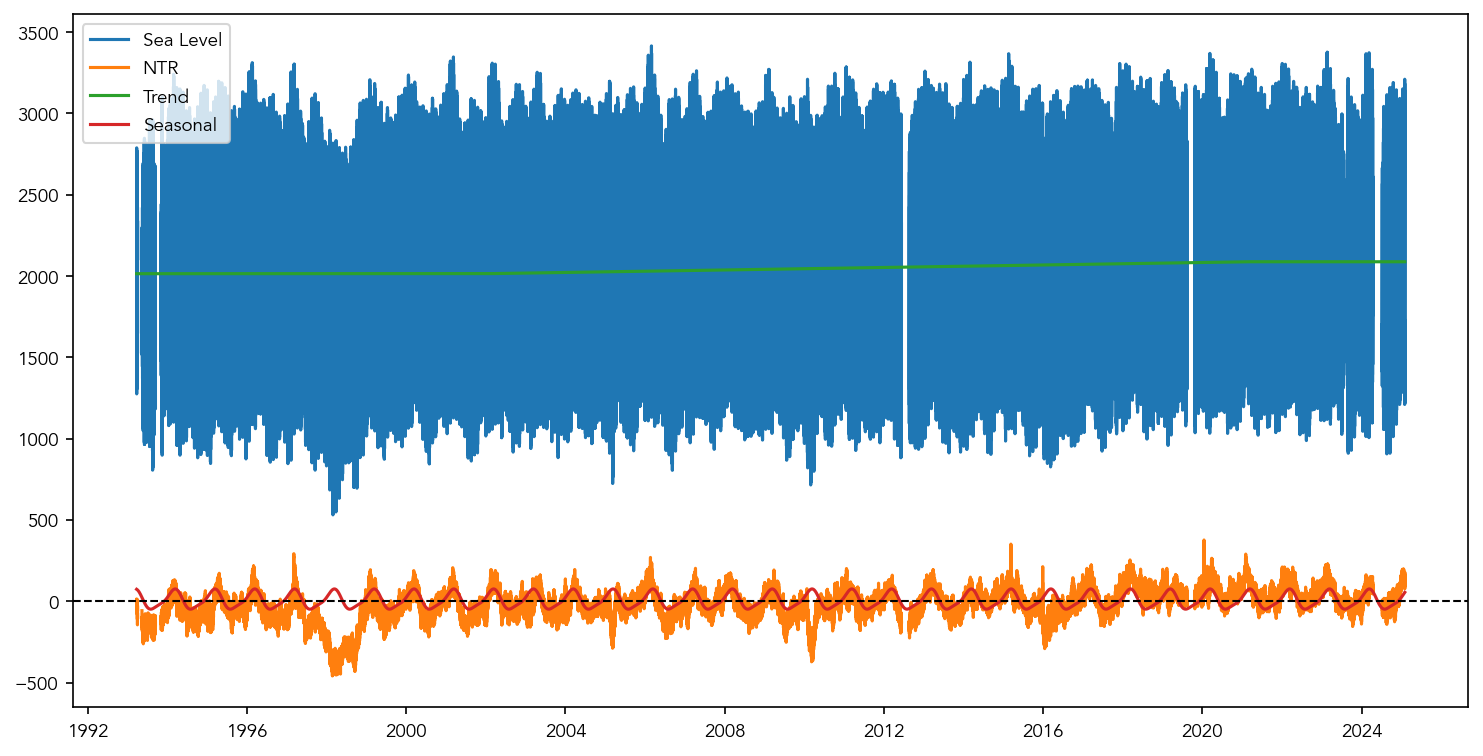

In [79]:
#plot sea level
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ntr_data.time, ntr_data.sea_level, label='Sea Level')
ax.plot(ntr_data.time, ntr_data.ntr , label='NTR')
ax.plot(ntr_data.time, ntr_data.trend, label='Trend')
ax.plot(ntr_data.time, ntr_data.seasonal_cycle, label='Seasonal')

# add zero line
ax.axhline(0, color='k', linestyle='--', lw=1)

# add legend
ax.legend()

### Plot and Inspect
We're looking at the NTR with and without the nodal modulation removed.

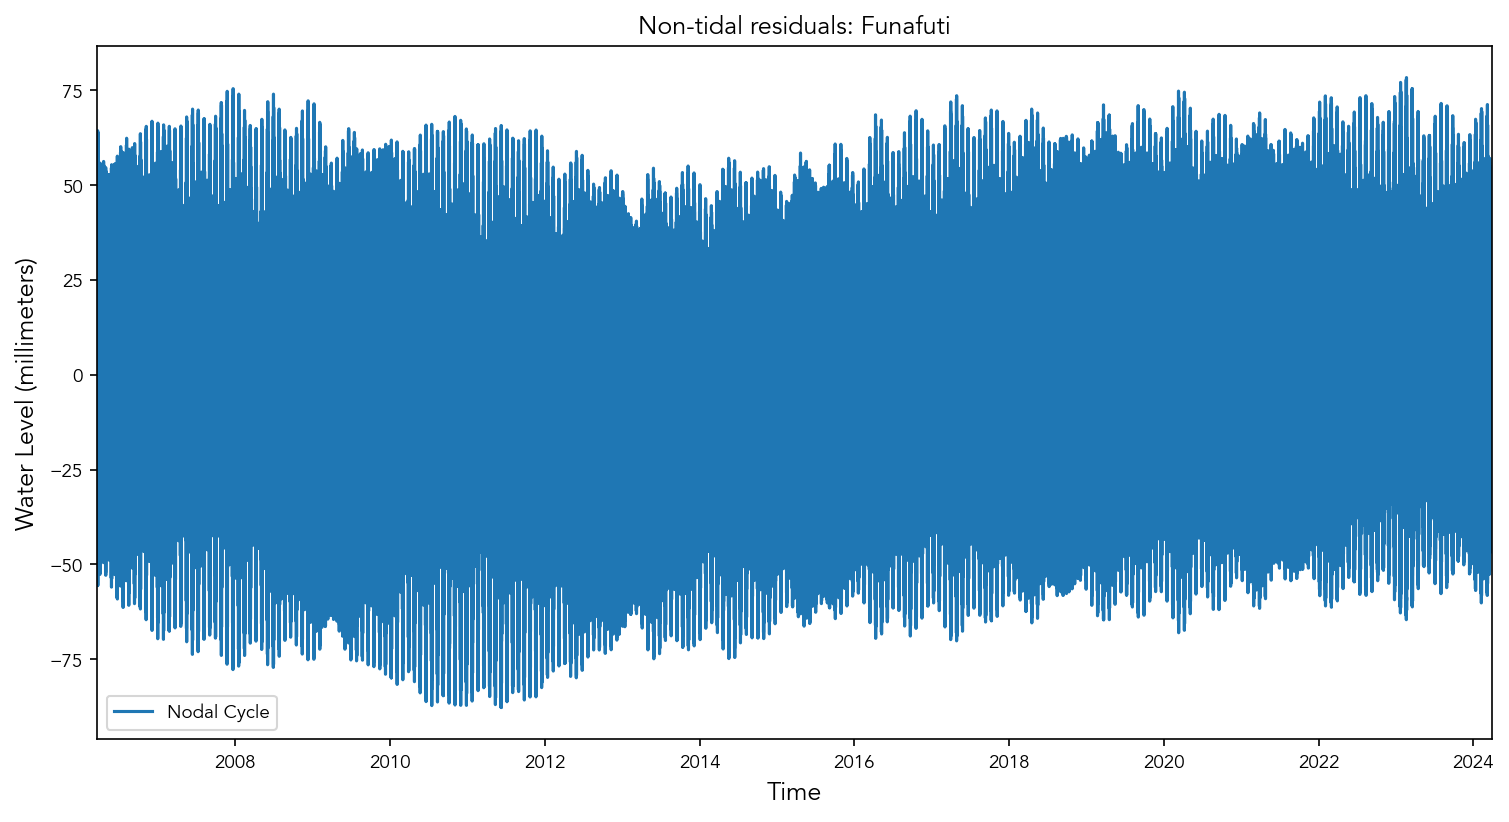

In [80]:
#plot time series
plt.figure(figsize=(12, 6))
# plt.plot(ntr_data['time'], ntr_data['ntr_withNodal'], label='NTR, nodal cycle not accounted for')
# plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
# plt.plot(ntr_data['time'], ntr_data['tide'], label='Predicted Tide')

# plt.plot(ntr_data['time'], ntr_data['ntr'] , label='Nodal modulated signal (NTR with nodal cycle - NTR without nodal cycle)')

plt.plot(ntr_data['time'], ntr_data['nodal'], label='Nodal Cycle')

# add title
plt.title('Non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Water Level' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2000-2005
plt.xlim([np.datetime64('2006-03-21'), np.datetime64('2024-03-30')])
plt.legend()


## First, let's see if there's a seasonal cycle
We'll do this by fitting an annual and semi-annual cycle to day-of-year data.

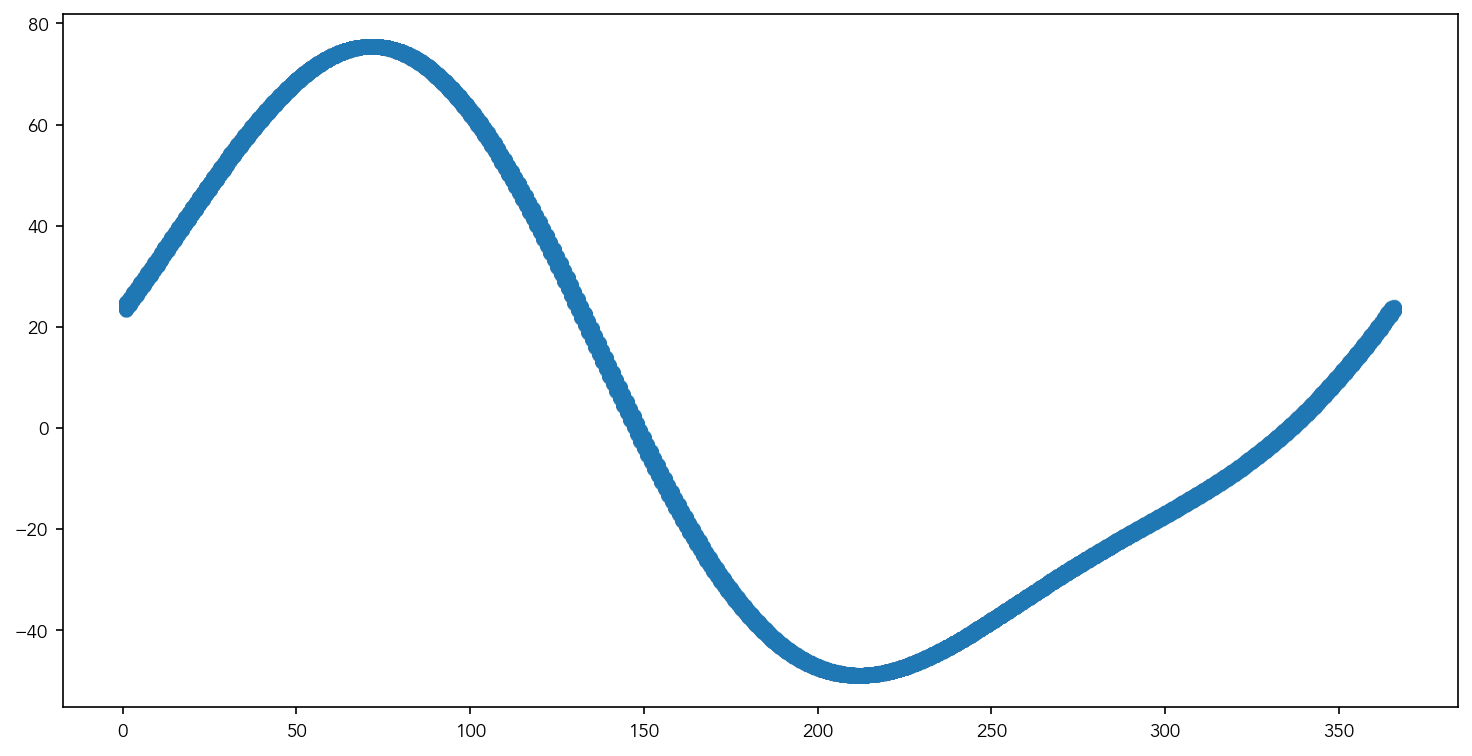

In [81]:
#convert timeseries to day of year
ntr_data['dayofyear'] = ntr_data['time'].dt.dayofyear
#plot time series with day of year
plt.figure(figsize=(12, 6))
plt.scatter(ntr_data['dayofyear'], ntr_data['seasonal_cycle'], label='NTR with Nodal Cycle', alpha=0.05)

Text(0.5, 0, 'Day of year')

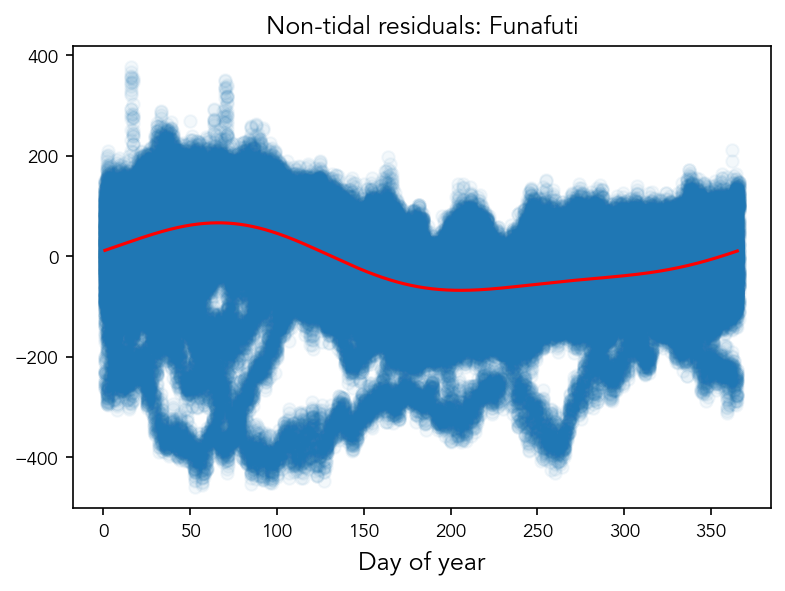

In [82]:
# Fit an annual and semi-annual cycle to the data
from scipy.optimize import curve_fit
from scipy.optimize import minimize
def seasonal_cycle(x, a, b, c, d, e):
    return a * np.sin(2 * np.pi * (x - b) / 365.25) + c * np.sin(2 * np.pi * (x - d) / 182.25) + e


# Remove rows with NaN values in 'ntr' or 'dayofyear'
filtered_data = ntr_data.dropna(subset=['ntr', 'dayofyear'])

# Fit the seasonal cycle to the filtered data
# Define a function to minimize the absolute deviation (median fitting)
def median_loss(params, x, y):
    return np.sum(np.abs(y - seasonal_cycle(x, *params)))

# Initial guess for the parameters
initial_guess = [1, 1, 1, 1, 1]

# Perform the minimization
result = minimize(median_loss, initial_guess, args=(filtered_data['dayofyear'], filtered_data['ntr']))

# Extract the optimized parameters
popt = result.x

# Plot the fitted seasonal cycle
x = np.linspace(1, 365, 1000)
plt.plot(x, seasonal_cycle(x, *popt), color='red', label='Fitted seasonal cycle')
plt.scatter(ntr_data['dayofyear'], ntr_data['ntr'], label='NTR', alpha=0.05)
plt.title('Non-tidal residuals: ' + station_name)
plt.xlabel('Day of year')

In [83]:
#standard deviation of the seasonal cycle
seasonal_cycle_std = np.std(seasonal_cycle(filtered_data['dayofyear'], *popt))
print('Standard deviation of the seasonal cycle:', seasonal_cycle_std)

Standard deviation of the seasonal cycle: 45.671520565712214


Text(0.5, 0, 'Time')

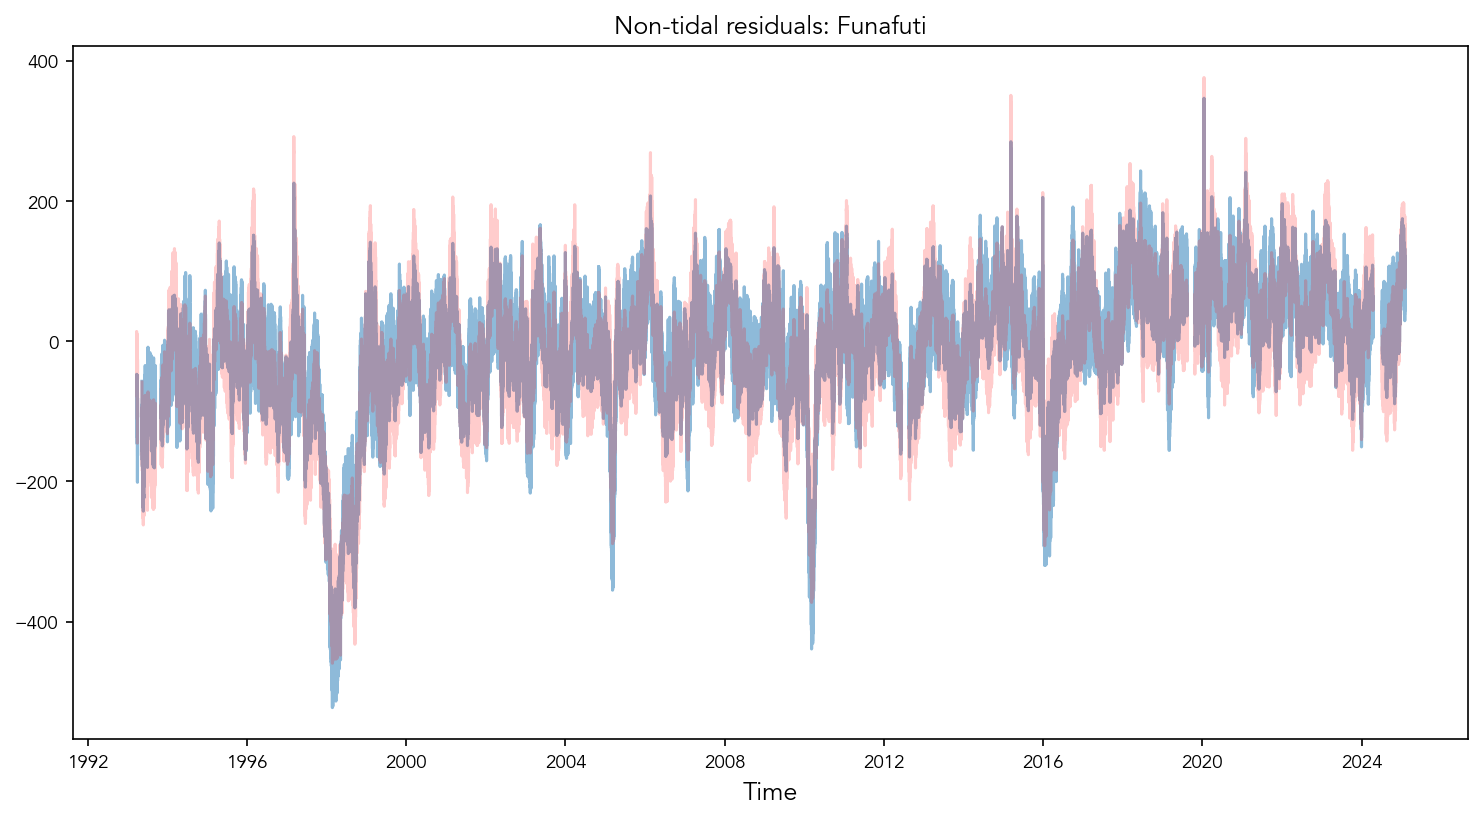

In [84]:
# Generate the full seasonal cycle in the original time domain
ntr_data['seasonal_cycle'] = seasonal_cycle(ntr_data['dayofyear'], *popt)
# Plot the original data and the fitted seasonal cycle
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], ntr_data['ntr']-ntr_data['seasonal_cycle'], label='NTR, Seasonal cycle removed', alpha=0.5)
plt.plot(ntr_data['time'], ntr_data['ntr'], color='red', label='NTR', alpha=0.2)
plt.title('Non-tidal residuals: ' + station_name)
plt.xlabel('Time')

### Let's examine the Nodal modulation a bit more
As noted by others studying the Honolulu tide gauge (e.g. Thompson et al), the modulation of the nodal cycle on the 99th percentile water levels can affect high sea levels by up to 5cm. In low-lying areas this contribution can be significant. Here, we'll simulate this effect by taking the upper envelope of the yearly max of the nodal modulation. 

In [113]:
# # Let's try treating the nodal cycle  in terms of its envelope 
# Fit the upper envelope to a sinusoidal function with a period of 18.61 years
# The following code is adapted from Thompson et al. (2021), Projected 
# high-tide flooding in the United States: Rapid increases and extreme months, Nature Climate Change.

nodal = ntr_data['nodal'].copy()
nodal = nodal - nodal.mean()  # remove the mean
# set index to time
nodal.index = ntr_data['time']

# Calculate rolling max
rolling_max = nodal.rolling('60D', min_periods=1).max()

# Use 99.9th and 0.1th percentiles for yearly max/min
nodal_max = rolling_max.resample('YS').quantile(0.999)
nodal_min = rolling_max.resample('YS').quantile(0.001)
nodal_max_real_date = rolling_max.groupby(rolling_max.index.to_period('Y')).idxmax()
nodal_max.index = pd.to_datetime(nodal_max_real_date.values)


def n_sine(t, A, phase, offset):
    omega = 2 * np.pi / 18.61
    return offset + A * np.sin(omega * t + phase )



def skewed_sine(t, A, phase, skew, offset):
    omega = 2 * np.pi / 18.61
    return offset + A * np.sin(omega * t + phase + skew * np.sin(omega * t + phase))

from scipy.optimize import curve_fit


def get_mod_envelope(tide, fit_times, eval_times):
    """
    Fit the double sine to the data at fit_times, then evaluate on eval_times.
    """
    # Initial guesses: [A1, phase1, skew, offset]
    p0 = [np.std(tide.values), 0, np.mean(tide.values)]

    # Fit times (e.g., yearly_max.index)
    fit_dates = pd.to_datetime(fit_times)
    t0 = fit_dates[0]
    t_fit_float = (fit_dates - t0).total_seconds() / (365.25 * 24 * 3600)  # years since t0

    # Fit the model
    popt, _ = curve_fit(n_sine, t_fit_float, tide.values, p0=p0)

    # Evaluate on eval_times (e.g., tide.index)
    eval_dates = pd.to_datetime(eval_times)
    t_eval_float = (eval_dates - t0).total_seconds() / (365.25 * 24 * 3600)
    fit_eval = n_sine(t_eval_float, *popt)
    fit_series = pd.Series(fit_eval, index=eval_times)

    return fit_series

# def get_mod_envelope(nodal, t):

#     # Initial guesses: A, phase, skew
#     p0 = [np.std(nodal.values), 0, 0, np.mean(nodal.values)]  # amplitude ~ std of signal, phase = 0, no skew

#     # Fit
#     popt, _ = curve_fit(skewed_sine, t, nodal.values, p0=p0)

#     A_fit, phase_fit, skew_fit, offset_fit = popt

#     ncyc_upper = skewed_sine(t, *popt)

#     # make series
#     # ncyc_upper = pd.Series(ncyc_upper, index=nodal.index + pd.DateOffset(days=365.25/24))
#     ncyc_upper = pd.Series(ncyc_upper, index=pd.to_datetime({
#                         'year': nodal.index.year,
#                         'month': nodal.index.month,
#                         'day': 15
#                     }))
#     return ncyc_upper

# Fit the upper envelope
ncyc_upper = get_mod_envelope(nodal_max, nodal_max.index, tide.index)
# Fit the lower envelop
ncyc_lower = get_mod_envelope(nodal_min, nodal_min.index, tide.index)

ncyc_mod_upper = np.max(ncyc_upper) - np.min(ncyc_upper)
ncyc_mod_lower = np.max(ncyc_lower) - np.min(ncyc_lower)

print('Nodal cycle amplitude:', str(round(ncyc_mod_upper*0.1, 2)) , 'cm')


Nodal cycle amplitude: 1.32 cm


In [104]:
# # Let's try fitting  cycle  in terms of its envelope 
# Fit the upper envelope to a sinusoidal function with a period of 18.61 years or 4.4 for perigean tides.
# The following code is adapted from Thompson et al. (2021), Projected 
# high-tide flooding in the United States: Rapid increases and extreme months, Nature Climate Change.


tide = ntr_data['tide'].copy()
tide = tide + ntr_data['nodal']  # add the nodal cycle back
tide.index = ntr_data['time']
#exclude 1993 and 2025
tide = tide[(tide.index.year != 1993) & (tide.index.year != 2025)]
tide = tide - tide.mean()  # remove the mean
# set index to time


# Calculate rolling max
rolling_max = tide.rolling('60D', min_periods=1).max()
monthly_max = rolling_max.resample('MS').max()
monthly_min = rolling_max.resample('MS').min()
monthly_max_real_date = rolling_max.groupby(rolling_max.index.to_period('M')).idxmax()
monthly_max.index = pd.to_datetime(monthly_max_real_date.values)

# Use 99.9th and 0.1th percentiles for yearly max/min
yearly_max = rolling_max.resample('YS').quantile(0.999)
yearly_min = rolling_max.resample('YS').quantile(0.001)
yearly_max_real_date = rolling_max.groupby(rolling_max.index.to_period('Y')).idxmax()
yearly_max.index = pd.to_datetime(yearly_max_real_date.values)

def perigee_double_sine(t, A1, phase1, A2, phase2, offset):
    omega1 = 2 * np.pi / 4.425
    omega2 = 2 * np.pi / 8.85
    return (offset
            + A1 * np.sin(omega1 * t + phase1 )
            + A2 * np.sin(omega2 * t + phase2 ))

def perigee_sine(t, A1, phase1, skew1, offset):
    omega1 = 2 * np.pi / 4.425
    return (offset
            + A1 * np.sin(omega1 * t + phase1 + skew1 * np.sin(omega1 * t + phase1)))

def nodal_skewed_sine(t, A1, phase1, skew1, offset):
    omega1 = 2 * np.pi / 18.61
    return (offset
            + A1 * np.sin(omega1 * t + phase1 + skew1 * np.sin(omega1 * t + phase1)))


def nodal_sine(t, A1, phase1, offset):
    omega1 = 2 * np.pi / 18.61
    return (offset
            + A1 * np.sin(omega1 * t + phase1 ))

from scipy.optimize import curve_fit


def get_mod_envelope_double(tide, fit_times, eval_times):
    """
    Fit the double sine to the data at fit_times, then evaluate on eval_times.
    """
    # Initial guesses: [A1, phase1, skew1, A2, phase2, offset]
    p0 = [np.std(tide.values), 0, np.std(tide.values)/2, 0, np.mean(tide.values)]
    # p0 = [np.std(tide.values), 0, 0,np.mean(tide.values)]


    # Fit times (e.g., yearly_max.index)
    fit_dates = pd.to_datetime(fit_times)
    t0 = fit_dates[0]
    t_fit_float = (fit_dates - t0).total_seconds() / (365.25 * 24 * 3600)  # years since t0

    # Fit the model
    popt, _ = curve_fit(perigee_double_sine, t_fit_float, tide.values, p0=p0)
    # popt, _ = curve_fit(perigee_sine, t_fit_float, tide.values, p0=p0)


    # Evaluate on eval_times (e.g., tide.index)
    eval_dates = pd.to_datetime(eval_times)
    t_eval_float = (eval_dates - t0).total_seconds() / (365.25 * 24 * 3600)
    fit_eval = perigee_double_sine(t_eval_float, *popt)
    fit_series = pd.Series(fit_eval, index=eval_times)

    return fit_series

def get_mod_envelope_nodal(tide, fit_times, eval_times):
    """
    Fit the nodal sine to the data at fit_times, then evaluate on eval_times.
    """
    # Initial guesses: [A1, phase1, skew1, A2, phase2, offset]
    # p0 = [np.std(tide.values), 0, np.std(tide.values)/2, 0, np.mean(tide.values)]
    # p0 = [np.std(tide.values), 0, 0,np.mean(tide.values)]
    p0 = [np.std(tide.values), 0, np.mean(tide.values)]


    # Fit times (e.g., yearly_max.index)
    fit_dates = pd.to_datetime(fit_times)
    t0 = fit_dates[0]
    t_fit_float = (fit_dates - t0).total_seconds() / (365.25 * 24 * 3600)  # years since t0

    # Fit the model
    popt, _ = curve_fit(nodal_sine, t_fit_float, tide.values, p0=p0)
    # popt, _ = curve_fit(perigee_sine, t_fit_float, tide.values, p0=p0)


    # Evaluate on eval_times (e.g., tide.index)
    eval_dates = pd.to_datetime(eval_times)
    t_eval_float = (eval_dates - t0).total_seconds() / (365.25 * 24 * 3600)
    fit_eval = nodal_sine(t_eval_float, *popt)
    fit_series = pd.Series(fit_eval, index=eval_times)

    return fit_series

# Fit the upper envelope with both cycles
pcyc_upper_double = get_mod_envelope_double(yearly_max, yearly_max.index, tide.index)
pcyc_lower_double = get_mod_envelope_double(yearly_min, yearly_min.index, tide.index)

# Amplitudes
pcyc_mod_upper_double = np.max(pcyc_upper_double) - np.min(pcyc_upper_double)
pcyc_mod_lower_double = np.max(pcyc_lower_double) - np.min(pcyc_lower_double)


# Fit the upper envelope with both cycles
nodal_upper = get_mod_envelope_nodal(yearly_max, yearly_max.index, tide.index)
nodal_lower = get_mod_envelope_nodal(yearly_min, yearly_min.index, tide.index)

# Amplitudes
nodal_upper_amp = np.max(nodal_upper) - np.min(nodal_upper)
nodal_lower_amp = np.max(nodal_lower) - np.min(nodal_lower)

print('Lunar Perigean cycle amplitude:', str(round(pcyc_mod_upper_double*0.1, 2)), 'cm')
print('Nodal cycle amplitude:', str(round(nodal_upper_amp*0.1, 2)), 'cm')


Lunar Perigean cycle amplitude: 5.0 cm
Nodal cycle amplitude: 0.91 cm


Text(0, 0.5, 'Predicted Water Level (cm)')

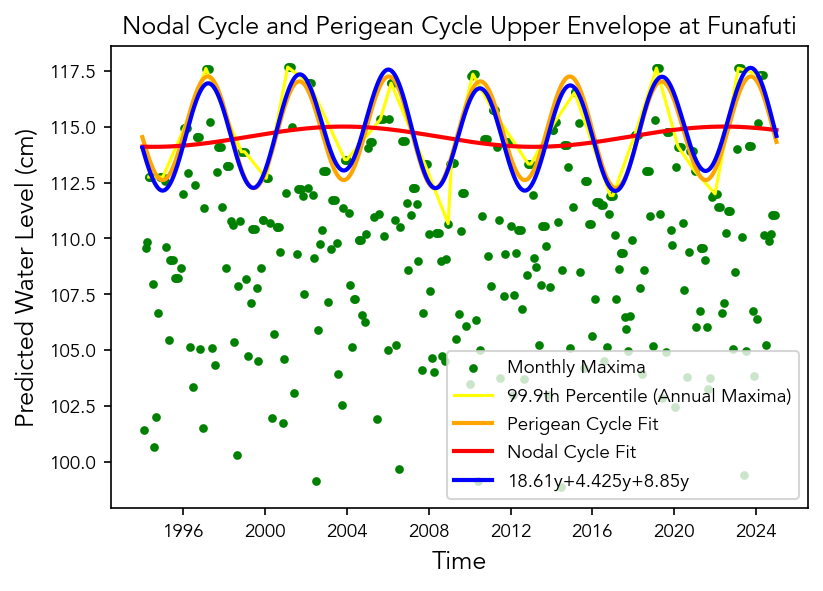

In [124]:
plt.scatter(monthly_max_real_date,0.1*monthly_max, label='Monthly Maxima', color='green',s=10)
plt.plot(yearly_max.index,0.1*yearly_max, label='99.9th Percentile (Annual Maxima)', color='yellow')
# plt.scatter(nodal_upper_envelope.index,0.1*nodal_upper_envelope, label='Nodal Cycle Upper Envelope Monthly', color='magenta',s=3)
# plt.scatter(nodal_upper_envelope1.index,0.1*nodal_upper_envelope1, label='Nodal Cycle Upper Envelope Monthly', color='yellow',s=3)


plt.plot(pcyc_upper_double.index, 0.1*(pcyc_upper_double), label='Perigean Cycle Fit', color='orange', lw=2)
plt.plot(nodal_upper.index, 0.1*(nodal_upper), label='Nodal Cycle Fit', color='red', lw=2)
plt.plot(ncyc_upper.index, 0.1*(nodal_upper-nodal_upper.mean()+pcyc_upper_double), label='18.61y+4.425y+8.85y', color='blue', lw=2)
# add legend
plt.legend()

# add title
plt.title('Nodal Cycle and Perigean Cycle Upper Envelope at ' + station_name)
plt.xlabel('Time')
plt.ylabel('Predicted Water Level (cm)')
# interpolate the pyc_upper_double to the nodal cycle upper envelope

#set xlimits to just 2000-2022
# plt.xlim([np.datetime64('2010-01-01'), np.datetime64('2022-12-31')])



In [89]:
#extract top 5 tides
top_tides = ntr_data.nlargest(10, 'tide')
print('Top tides:')
print(top_tides[['time', 'tide']])

Top tides:
                      time         tide
271420 2024-03-10 05:00:00  1192.028516
34013  1997-02-08 06:00:00  1188.626141
227141 2019-02-20 06:00:00  1186.397926
147773 2010-01-31 06:00:00  1182.554473
78317  2002-02-28 06:00:00  1182.503971
113380 2006-02-28 05:00:00  1180.753806
192052 2015-02-19 05:00:00  1180.451855
227116 2019-02-19 05:00:00  1179.525805
262204 2023-02-20 05:00:00  1176.454547
33988  1997-02-07 05:00:00  1175.640891


Text(0.5, 1.0, 'Nodal and Perigean Cycles: Funafuti')

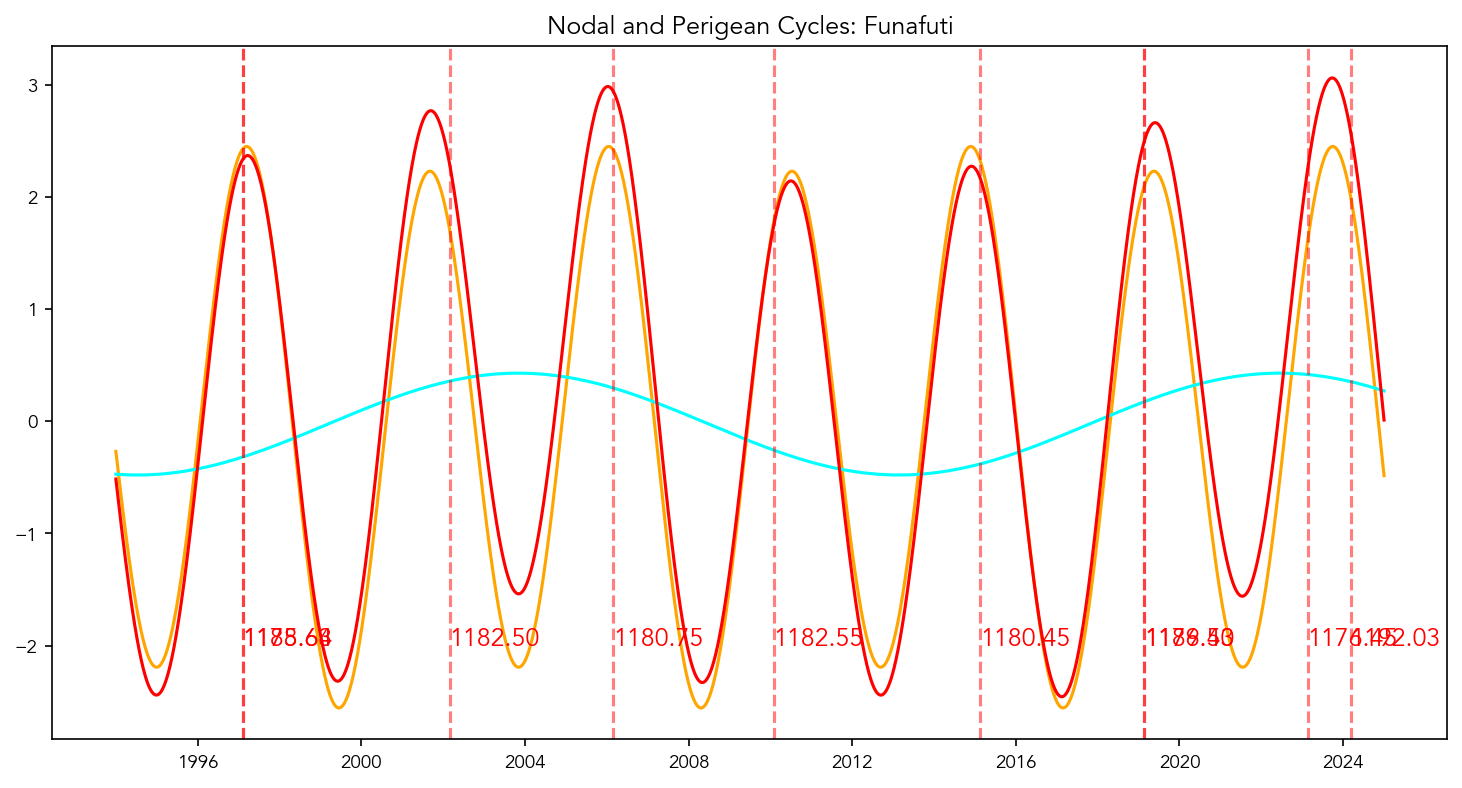

In [128]:
# plot the nodal and perigean cycles
plt.figure(figsize=(12, 6))
# plt.plot(ncyc_upper.index, 0.1*(ncyc_upper-ncyc_upper.mean()), label='Nodal Cycle Upper Envelope', color='blue')
plt.plot(pcyc_upper_double.index, 0.1*(pcyc_upper_double-pcyc_upper_double.mean()), label='Perigean Cycle Upper Envelope', color='orange')
# plt.plot(pcyc_upper_double.index, 0.1*(pcyc_upper_double-pcyc_upper_double.mean()+ncyc_upper-ncyc_upper.mean()), label='Perigean Cycle Upper Envelope', color='orange')
plt.plot(nodal_upper.index, 0.1*(nodal_upper-nodal_upper.mean()), label='Nodal Cycle Upper Envelope', color='cyan')
plt.plot(pcyc_upper_double.index, 0.1*(pcyc_upper_double-nodal_upper.mean()+nodal_upper-nodal_upper.mean()), label='Perigean Cycle Upper Envelope', color='red')
# plt.plot(ptime, 0.1*(ncyc_upper-ncyc_upper.mean()), label='Astronomical Stuff', color='cyan')

#mark the top 5 tides withv ertical lines
for i, row in top_tides.iterrows():
    plt.axvline(row['time'], color='red', linestyle='--', alpha=0.5)
    plt.text(row['time'], -2, f"{row['tide']:.2f}", color='red', fontsize=12)
plt.title('Nodal and Perigean Cycles: ' + station_name)


Does the epoch used for analysis matter here? We use 18.6 for the nodal cycle but what if the that's messing up our lunar perigean calculation??

In [387]:
ntr_data

,time,ntr,sea_level,sea_level_detrended,trend,tide,nodal,ntr_withNodal,seasonal_cycle,dayofyear
0,1993-03-24 01:00:00,-48.300066,1455.0,-595.32660,2014.163568,-547.026533,-12.566312,-102.565316,61.161849,83
1,1993-03-24 02:00:00,13.983822,1850.0,-200.32658,2014.163568,-214.310406,-13.683600,-39.148672,61.161849,83
2,1993-03-24 03:00:00,-29.368308,2193.0,142.67342,2014.163568,172.041724,-9.242565,-86.926312,61.161849,83
3,1993-03-24 04:00:00,-2.480913,2560.0,509.67343,2014.163568,512.154345,0.437328,-69.703228,61.161849,83
4,1993-03-24 05:00:00,-23.957869,2744.0,693.67340,2014.163568,717.631270,12.846238,-103.573455,61.161849,83
...,...,...,...,...,...,...,...,...,...,...
279282,2025-01-31 19:00:00,112.237675,2970.0,919.67340,2087.602358,807.435726,11.534960,53.002703,46.341107,31
279283,2025-01-31 20:00:00,135.169370,2848.0,797.67340,2087.602358,662.504031,3.511200,83.919690,46.341107,31
279284,2025-01-31 21:00:00,123.068119,2517.0,466.67343,2087.602358,343.605312,-4.133467,79.424656,46.341107,31
279285,2025-01-31 22:00:00,178.821187,2165.0,114.67342,2087.602358,-64.147763,-9.846747,140.852572,46.341107,31


(8401.0, 20148.0)

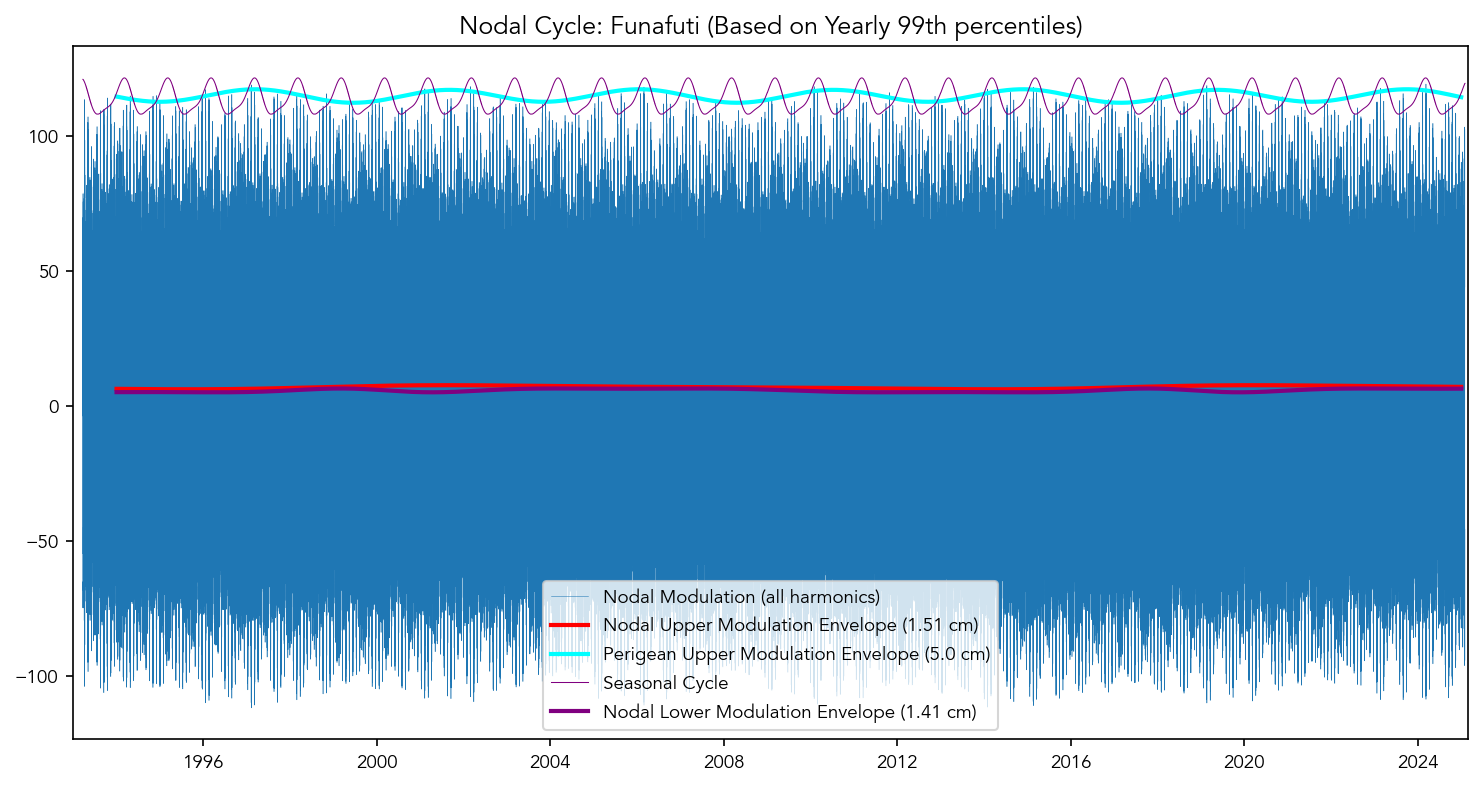

In [ ]:
# #plot the nodal signal and the envelope
# plt.figure(figsize=(12, 6))
# plt.plot(ntr_data['time'], 0.1*ntr_data['tide'], label='Predicted Tide',linewidth=0.25)
# plt.plot(ncyc_upper.index, 0.1*ncyc_upper, label='Nodal Upper Modulation Envelope (' + str(round(ncyc_mod_upper*0.1, 2)) + ' cm)', color='red', linewidth=2)
# plt.plot(pcyc_upper_double.index, 0.1*pcyc_upper_double, label='Perigean Upper Modulation Envelope (' + str(round(pcyc_mod_upper_double*0.1, 2)) + ' cm)', color='cyan', linewidth=2)
# # plt.scatter(monthly_max_real_date,0.1*monthly_max, label='Monthly Maxima', color='green',s=3)
# plt.plot(ntr_data['time'], 0.1*ntr_data['seasonal_cycle']+0.1*pcyc_upper_double.mean(), label='Seasonal Cycle', color='purple', linewidth=0.5)
# plt.plot(ncyc_lower.index, 0.1*ncyc_lower, label='Nodal Lower Modulation Envelope (' + str(round(ncyc_mod_lower*0.1, 2)) + ' cm)', color='purple', linewidth=2)
# # plt.scatter(ncyc_lower.index, 0.1*nodal_lower_envelope, label='Yearly 1st percentile', color='cyan', linestyle='-', linewidth=2)

# plt.title('Nodal Cycle: ' + station_name + ' (Based on Yearly 99th percentiles)')

# plt.legend()
# #set x-axis to 2017-2018
# plt.xlim([np.datetime64('1993-01-01'), np.datetime64('2025-03-01')])

(8401.0, 20148.0)

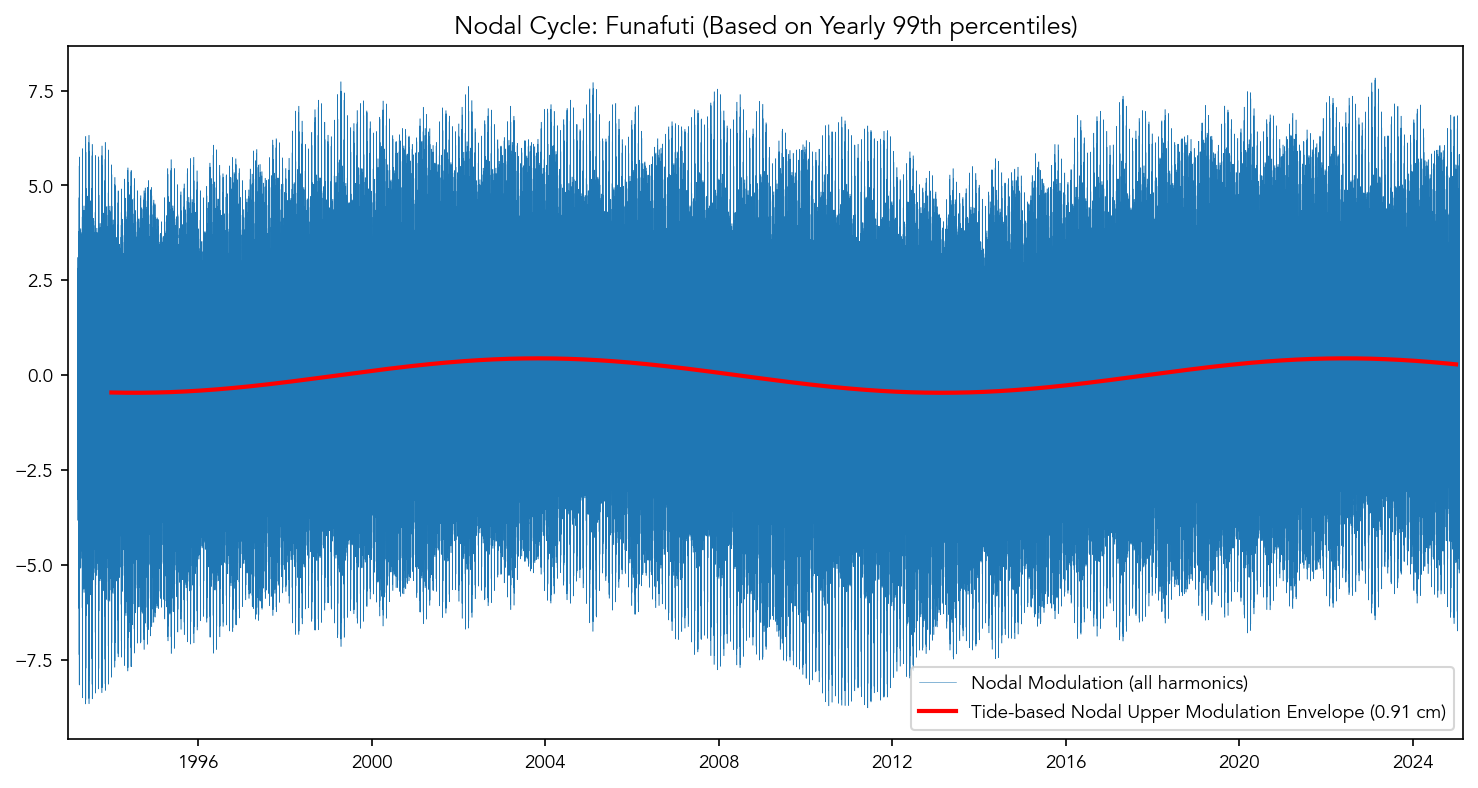

In [107]:
#plot the nodal signal and the envelope
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], 0.1*ntr_data['nodal'], label='Nodal Modulation (all harmonics)',linewidth=0.25)
plt.plot(nodal_upper.index, 0.1*(nodal_upper - yearly_max.mean()), label='Tide-based Nodal Upper Modulation Envelope (' + str(round(nodal_upper_amp*0.1, 2)) + ' cm)', color='red', linewidth=2)
# plt.plot(ncyc_upper1.index, 0.1*(ncyc_upper1), label='Nodal-based Nodal Upper Modulation Envelope (' + str(round(ncyc_mod_upper1*0.1, 2)) + ' cm)', color='orange', linewidth=2)


# plt.plot(pcyc_upper.index, 0.1*pcyc_upper, label='Perigean Upper Modulation Envelope (' + str(round(pcyc_mod_upper*0.1, 2)) + ' cm)', color='cyan', linewidth=2)
# plt.scatter(ncyc_upper.index, 0.1*nodal_upper_envelope, label='Yearly 99th percentile', color='orange', linestyle='-', linewidth=2)
# plt.plot(ncyc_lower1.index, 0.1*ncyc_lower1, label='Nodal Lower Modulation Envelope (' + str(round(ncyc_mod_lower*0.1, 2)) + ' cm)', color='purple', linewidth=2)
# plt.scatter(ncyc_lower.index, 0.1*nodal_lower_envelope, label='Yearly 1st percentile', color='cyan', linestyle='-', linewidth=2)

plt.title('Nodal Cycle: ' + station_name + ' (Based on Yearly 99th percentiles)')

plt.legend()
#set x-axis to 2017-2018
plt.xlim([np.datetime64('1993-01-01'), np.datetime64('2025-03-01')])

In [ ]:
# ntr_data['time'] = pd.to_datetime(ntr_data['time'])
# ntr_data = ntr_data.set_index('time')
#make subset dataframe of ntr data with just ntr and time
sea_level_data = ntr_data[['ntr','time']].copy()
# sea_level_data['time'] = ntr_data['time']
ntr_data_mags,ntr_trend_series,ntr_trend_rates = process_trend_with_nan(sea_level_data)
# sea_level_data
ntr_data['ntr_detrended'] = ntr_data['ntr'] - ntr_trend_series['ntr'] 

In [ ]:
ntr_data_mags


In [ ]:
plt.plot(ntr_data['time'], ntr_data['ntr_detrended'], label='NTR detrended')
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
plt.plot(ntr_data['time'], ntr_trend_series['ntr'], label='Trend')
plt.legend()

# add title
plt.title('Detrended non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2001 Jan to Feb
# plt.xlim([np.datetime64('2017-10-01'), np.datetime64('2017-10-02')])

# set y-axis to -0.1 to 0.1
# plt.ylim([0,200])

In [ ]:
# Now start to filter for each frequency band we want

# make time_diffs in hours
time_diffs = np.diff(ntr_data['time']).astype('timedelta64[h]').astype(int)
widthSeasonal = 1/365.25/10; #1 cycle per decade



```{caution}
The timescales probably need some refinement. For example: mesoscale processes. Higher the latitude the longer the period!!
```
From Chen, S., and B. Qiu (2010), Mesoscale eddies northeast of the Hawaiian archipelago from satellite altimeter observations, J. Geophys. Res., 115, C03016, doi:10.1029/2009JC005698


"We define dominant periods of the mesoscale eddy activity by locating the periods at which the spectral peaks within the mesoscale range of 90–180 days. This definition is crude yet robust for the subregions with sharp spectral peaks like the 24°N–27°N, 160°W–155°W one (130 days) and the 18°N–21°N, 170°W–165°W one (90 days), but is also applicable to other subregions. In the lee of the island of Hawaii, 90 day oscillations dominate the mesoscale eddy activity. In the subregions between 24°N and 30°N, a 130 day peak often prevails, but in the 30°N–33°N band, a weak 180 day peak emerges. The pattern is that the higher the latitude, the longer the dominant period."

Also:
Firing, Y. L., and M. A. Merrifield (2004), Extreme sea level events at Hawaii: Influence of mesoscale eddies, Geophys. Res. Lett., 31, L24306, doi:10.1029/2004GL021539.

In [ ]:
ntr_data

In [ ]:
# Define timescales (in days)
annual = 365.25
biannual = 365.25*2
semiannual = 365.25/2
qtrannual = 365.25/4
daily = 7
weekly = 365.25/12
monthly = 3*365.25/12
decadal = 7*365.25
# interdecadal = 30*365.25


# make a dictionary of the timescales and the processes
timeframes = {'Decadal': 'e.g. PDO, 7-30+ yr', 
            #   'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-7 yr', 
              'Subannual': '3 months - 1 years', 
              'Monthly': '1 - 3 months',
              'Weekly': '1 -4 weeks', 
              'Storms & HF': '& other short-term variability',
              'Nodal Amp': '18.6 yr tidal modulation'}

# interpolate ncyc to the same time as ntr_data
ncyc_interp = ncyc_upper.reindex(ntr_data['time']).interpolate(method='linear')


In [ ]:

def filter_ntr(ntr_data):
    # ntr_noAnnual, ntr_Annual = filter_known_frequency_components(ntr_data['ntr_detrended'], time_diffs,1/annual , width=widthSeasonal)
    # ntr_noSemiAnnual, ntr_SemiAnnual = filter_known_frequency_components(ntr_noAnnual, time_diffs, 1/semiannual, width=widthSeasonal)
    # ntr_noQtrAnnual, ntr_QtrAnnual = filter_known_frequency_components(ntr_noSemiAnnual, time_diffs, 1/qtrannual, width=widthSeasonal)
    # ntr_Seasonal = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual

    rec_length = (ntr_data['time'].max() - ntr_data['time'].min()).days
    
    # if rec_length < 35*365.25:
        #interdecadal
        # ntr_interdecadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr_detrended'], time_diffs, 1/interdecadal, order=3, padtype='even', padlen=3)
        #decadal
    ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr_detrended']-ntr_data['seasonal_cycle'] , time_diffs, 1/decadal, order=3) 
    #     ntr_decadal = ntr_decadal + ntr_interdecadal
    # else:
    #     #interdecadal
    #     ntr_interdecadal, ntr_highFreq = butterworth_lowpass(ntr_data['ntr_detrended'], time_diffs, 1/interdecadal, order=3, padtype='even', padlen=3)
    #     #decadal
    #     ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/decadal, order=3)
    
    #interannual
    ntr_interannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/annual, order=3)

    # intraannual
    # this should be done in wavelets instead of a lowpass filter??

    ntr_subannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/monthly, order=5)

    ntr_monthly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/weekly, order=5)

    # Remove high frequencies (weekly to hourly)
    # ntr_weekly is timescales longer than 7 days but less than 1 month
    ntr_weekly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/daily, order=5)

    

    # make dataframe of filtered data
    ntr_filtered = pd.DataFrame({'time': ntr_data['time'], 
                             'ntr': ntr_data['ntr_detrended'], 
                             'sea_level': ntr_data['sea_level'],
                             'sea_level_detrended': ntr_data['sea_level_detrended'],
                             'tide': ntr_data['tide'],
                             'Nodal Amp': ncyc_interp.values,
                             'Nodal Mod': ntr_data['nodal'],
                             'Trend': ntr_data['trend'],
                            #  'Interdecadal': ntr_interdecadal, 
                             'Decadal': ntr_decadal, 
                             'Interannual': ntr_interannual, 
                             'Seasonal': ntr_data['seasonal_cycle'], 
                             'Subannual': ntr_subannual, 
                             'Monthly': ntr_monthly,
                             'Weekly': ntr_weekly, 
                             'Storms & HF': ntr_highFreq,
                             'NTR Trend': ntr_trend_series['ntr']})

    # if rec_length < 35*365.25:
    #     ntr_filtered.pop('Interdecadal')

    component_names = list(ntr_filtered.columns) 
    component_names.remove('time')
    component_names.remove('ntr')
    component_names.remove('sea_level')
    component_names.remove('sea_level_detrended')
    component_names.remove('Nodal Amp')
    component_names.remove('Nodal Mod')

    # add trend back into ntr
    ntr_filtered['ntr'] = ntr_filtered['ntr'] + ntr_filtered['NTR Trend']
    
    return ntr_filtered, component_names


In [ ]:
ntr_filtered,component_names = filter_ntr(ntr_data)

# get std of each component
ntr_component_stds = ntr_filtered.std()

# remove time from ntr)component_stds
ntr_component_stds = ntr_component_stds.drop('time')

In [ ]:
# save ntr_component_stds to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station:03d}_component_stds.csv')
ntr_component_stds.to_csv(savepath)


In [ ]:
# look at filtered components of nodal cycle only
# nodal_data = ntr_data.copy()
# nodal_data.index = ntr_data['time']
# envelope_demeaned = envelope - np.nanmean(envelope)
# envelope_demeaned.index = nodal_data.index
# nodal_data['ntr_detrended'] = envelope_demeaned
# nodal_filtered = filter_ntr(nodal_data)

# #rename "ntr" in nodal_filtered to "nodal upper envelope"
# nodal_filtered = nodal_filtered.rename(columns={'ntr': 'nodal envelope'})

# nodal_component_std = nodal_filtered.std() 
# nodal_component_std = nodal_component_std.drop('time')



In [ ]:
ntr_filtered

In [ ]:
# ntr_component_stds

In [ ]:
# nodal_component_std
# nodal_corr = nodal_filtered.drop(['time','sea_level','tide'], axis=1).corr()
# #plot heatmap
# plt.figure(figsize=(5,4))
# sns.heatmap(nodal_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
# plt.title('Correlation Matrix\n of upper nodal envelope components')

Note that to define the upper envelope we used monthly maxima. So there should be NO correlation in the weekly/storms.

Next, a sanity check to make sure that everything adds up to the right sum.

In [ ]:
component_names
#remove Trend from component names
component_names.remove('Trend')
# component_names.remove('Seasonal')

In [ ]:
#plot ntr, then plot summed components
plt.figure(figsize=(2, 2))

# sum all components in components_names programmatically
ntr_sum = ntr_filtered[component_names].sum(axis=1)


#make a dotted 1:1 line
plt.plot(ntr_filtered['sea_level_detrended'], ntr_filtered['sea_level_detrended'], 'k:', label='1:1 line',linewidth=0.5,alpha=0.5)
plt.scatter(ntr_filtered['sea_level_detrended'], ntr_sum)

plt.xlabel('Sea Level')
plt.ylabel('Sum of components')

# add RMSD to plot
rmsd = np.sqrt(np.mean((ntr_filtered['sea_level_detrended'] - ntr_sum)**2))
plt.text(0.05, 0.95, f'RMSD: {rmsd:.2f} cm', ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.title('Sum of components vs Sea Level')


In [ ]:
#export data
# ntr_filtered.to_csv('data/ntr_filtered_059b.csv', index=False)
ntr_filtered.keys()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#make a heatmap plot of correlation between each component
ntr_corr = ntr_filtered.drop(['time','sea_level','sea_level_detrended','tide','ntr','Nodal Amp','Nodal Mod','NTR Trend','Trend','Seasonal'], axis=1).corr()

# add description to each component in ntr correlation matrix
ntr_corr.columns = [col + '\n' + timeframes[col] for col in ntr_corr.columns]
ntr_corr.index = [col + '\n' + timeframes[col] for col in ntr_corr.index]
#exclude time,sea_level, and tide from the correlation matrix

#plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(ntr_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation between each component')



Note there is correlation between some of these timeseries, likely due to the filtering process employed in this notebook. 

In [ ]:
# get the cumulative sum of the components
ntr_component_names = component_names.copy()
ntr_component_names.remove('tide')
# move trend and Seasonal to the beginning of the list
ntr_component_names.remove('Seasonal')
ntr_component_names.insert(0, 'Seasonal')
ntr_component_names.remove('NTR Trend')
# ntr_component_names.insert(0, 'NTR Trend')
ntr_cumsum = ntr_filtered[ntr_component_names].cumsum(axis=1)
ntr_cumsum_stds = ntr_cumsum.std()
ntr_cumsum_stds


# make a plot of ntr_filtered and ntr_cumsum
# fig, ax = plt.subplots(figsize=(12, 6))
# ntr_filtered.plot(x='time', y=['ntr'], ax=ax, color=['black'], linewidth=1)
# ntr_filtered_sums.plot(x='time', y=['Nodal'] +['> 20 years'], ax=ax, color='yellow',linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years'], ax=ax, linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years', '10-20 year', '1-10 year', 'Seasonal', '1 month - 1 year', '1 week - 1 month', '< 1 week'], ax=ax, linewidth=1, linestyle='--')


In [ ]:
ntr_filtered.keys()

In [ ]:
# Plot original vs. filtered signal
plt.figure(figsize=(12, 6))
plt.plot(ntr_filtered['time'], ntr_filtered['ntr']-ntr_filtered['NTR Trend'], label='Original Non-Tidal Residuals', color ="blue",alpha=0.5)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='$NTR - NTR_{hf}$', color='orange', linewidth=2)

# ntr_summed = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual + ntr_subAnnual + ntr_multiyear + ntr_decadal + ntr_lowFreq + ntr_monthly
# ntr_summed = ntr_filtered['Nodal']+ ntr_filtered['> 20 years'] + ntr_filtered['10-20 year'] + ntr_filtered['1-10 year'] + ntr_filtered['Seasonal'] + ntr_filtered['1 month - 1 year'] + ntr_filtered['1 week - 1 month'] + ntr_filtered['< 1 week']

# plt.plot(ntr_filtered['time'], ntr_summed, label='Sum of Filtered Components', color='red', linewidth=1)

plt.plot(ntr_filtered['time'], ntr_filtered['Nodal Amp'], label='Nodal Upper Envelope', color='green', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='> 20 years', color='orange', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Decadal'], label='Decadal', color='purple', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Interannual'], label='Interannual', color='brown', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Seasonal'], label='Seasonal', color='cyan', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Subannual'], label='Subannual', color='black', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['1 week - 2 month'], label='1 week - 2 month', color='pink', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['< 1 week'], label='< 1 week', color='grey', linewidth=1)
# plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR with Nodal Cycle')



plt.xlabel('Time')
plt.ylabel('Non-Tidal Residuals (mm)')
plt.title('Filtered Non-Tidal Residuals (Removing High-Frequency (>7 day) Components): ' + station_name)
plt.legend()
plt.grid()

# change xlim to zoom in
plt.xlim(pd.Timestamp('2015-12-25'), pd.Timestamp('2025-12-27'))
plt.ylim(-200, 200)
plt.show()

In [ ]:
ntr_filtered
#resample to monthly
ntr_filtered_monthly = ntr_filtered.resample('ME', on='time').mean()

In [ ]:
# Is the interannual component correlated with ENSO? Let's use the ONI index
# load ONI data

CI_dir = Path(data_dir / 'climate_indices')
climateIndex = ['AO','BEST','ONI','PDO','PMM','PNA','TNA']

CIcorr = np.zeros((len(climateIndex), 30))

# Arrays to store peak correlation and lag for each climate index
CIcorr_max_peaks = np.zeros(len(climateIndex))
CIcorr_max_lag = np.zeros(len(climateIndex))

for indCI in range(len(climateIndex)):
    CI = pd.read_csv(CI_dir / (climateIndex[indCI] + '.csv'), parse_dates=['time'])
    # ntr_CI = pd.merge_asof(ntr_filtered_monthly.sort_index(), CI.sort_index(), left_index=True, right_index=True, direction='nearest')
    CI['time'] = pd.to_datetime(CI['time'])

    # Perform the merge
    ntr_CI = pd.merge_asof(ntr_filtered_monthly, CI, left_index=True, right_on='time', direction='nearest')
    # Define the number of lags
    lag = 30
    corr = np.zeros(lag)

    if climateIndex[indCI] == 'PDO' or climateIndex[indCI] == 'PMM': #<--- IS THIS CORRECT?
        # For PDO and PMM, we need to add the decadal component to the interannual component
        ntr_CI['signal'] = ntr_CI['Interannual'] + ntr_CI['Decadal']
    else:
        # For other climate indices, we just use the interannual component
        ntr_CI['signal'] = ntr_CI['Interannual']


    # Calculate lagged correlation
    for i in range(1, lag + 1):
        corr[i - 1] = np.corrcoef(ntr_CI[climateIndex[indCI]][:-i], ntr_CI['signal'][i:])[0, 1]
    CIcorr[indCI,:] = corr
    # get max correlation and lag
    CIcorr_max_peaks[indCI] = np.max(abs(CIcorr[indCI,:]))
    CIcorr_max_lag[indCI] = np.argmax(abs(CIcorr[indCI,:]))

# Use the max correlation to determine the winning Climate Index
climateIndex_bestcorr = climateIndex[np.argmax(abs(CIcorr_max_peaks))]
climateIndex_bestlag = CIcorr_max_lag[np.argmax(abs(CIcorr_max_peaks))]

# now adjust the climateIndex by the lag and plot together with the ntr

CI = pd.read_csv(CI_dir / (climateIndex_bestcorr + '.csv'), parse_dates=['time'])
#adjust the time by the lag
CI['time'] = pd.to_datetime(CI['time'])
CI['time'] = CI['time'] + pd.DateOffset(months=CIcorr_max_lag[np.argmax(abs(CIcorr_max_peaks))])
# Perform the merge
ntr_CI = pd.merge_asof(ntr_filtered_monthly, CI, left_index=True, right_on='time', direction='nearest')
# rename the columns

#plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(ntr_CI['time'], ntr_CI['Interannual']+ntr_CI['Decadal'], label='Interannual NTR', color='blue')
# plt.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label=climateIndex_bestcorr, color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Non-Tidal Residuals (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for ONI
ax2 = ax1.twinx()
ax2.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label=climateIndex_bestcorr, color='red')
ylabel = climateIndex_bestcorr  + f' ({climateIndex_bestlag:.0f} month lead)'
ax2.set_ylabel(ylabel, color='red')
ax2.tick_params(axis='y', labelcolor='red')

corr = ntr_CI['Interannual'].corr(ntr_CI[climateIndex_bestcorr])
if corr < 0:
    ax2.invert_yaxis()  # Flip the axis

# add text for correlation
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}\n{climateIndex_bestcorr} leads NTR by {climateIndex_bestlag:.0f} months', ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.title('Interannual NTR and ' + climateIndex_bestcorr)

In [ ]:
ntr_CI

In [ ]:
ntr_component_stds
# save to csv

In [ ]:
#make a bar plot of the std of each component
import textwrap

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(ntr_component_stds.index, ntr_component_stds)
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=12)) for label in ntr_component_stds.index]
plt.xticks(range(len(ntr_component_stds.index)), wrapped_labels)
# plt.xticks(rotation=45)
ax.set_xlabel('Non-Tidal Residual Components')
ax.set_ylabel('Standard Deviation (mm)')
ax.set_title('Standard Deviation of Non-Tidal Residual Components: ' + station_name)


plt.show()

In [ ]:
# does the total variance of the components equal the variance of the ntr?

# get the variance of each component
ntr_component_vars = ntr_filtered.drop(['time','sea_level','sea_level_detrended','tide','ntr','Nodal Amp','Trend','Nodal Mod'], axis=1).var()

# get the sum of the variances
ntr_component_vars_sum = ntr_component_vars.sum()
# get the variance of the ntr
ntr_var = ntr_data['ntr'].var()

print('Sum of variances of components:', ntr_component_vars_sum)
print('Variance of ntr:', ntr_var)


print('"Wave Height" contributions:', 0.4* np.sqrt(ntr_component_vars_sum))
print('"Wave Height" ntr:', 0.4 * np.sqrt(ntr_var))

ntr_component_vars

# save ntr_component_vars to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station:03d}_component_vars2.csv')
ntr_component_vars.to_csv(savepath)



In [ ]:
ntr_data

In [ ]:
# "wave height" of each component
ntr_component_waveheight = ntr_cumsum_stds/10 *4
ntr_component_waveheight

# add long-term trend to the "wave height" stack, get trend value from Jan 1993 to Jan 2023
# get trend rate from ntr_data['NTR Trend'] 
SLR = ntr_filtered[['NTR Trend','time']].copy()
# set time as index
SLR['time'] = pd.to_datetime(SLR['time'])
SLR.set_index('time', inplace=True)
# get the slope of the trend - it is linear so just a-b over time
SLR_mm_day = (SLR['NTR Trend'].iloc[-1] - SLR['NTR Trend'].iloc[0]) / (SLR.index[-1] - SLR.index[0]).days 

SLR_cm30yr = SLR_mm_day*365.25/10 # convert to cm/yr

ntr_component_waveheight = pd.concat([pd.Series(SLR_cm30yr, index=['Long-Term Trend']), ntr_component_waveheight+SLR_cm30yr], axis=0)


# # add long-term trend to the "wave height" stack, get trend value from Jan 1993 to Jan 2023
# # get trend rate from ntr_data['trend'] 
# SLR = ntr_data[['trend','time']].copy()
# # set time as index
# SLR['time'] = pd.to_datetime(SLR['time'])
# SLR.set_index('time', inplace=True)
# # get the slope of the trend - it is linear so just a-b over time
# SLR_mm_day = (SLR['trend'].iloc[-1] - SLR['trend'].iloc[0]) / (SLR.index[-1] - SLR.index[0]).days 

# SLR_cm30yr = SLR_mm_day*365.25/10 # convert to cm/yr

# ntr_component_waveheight = pd.concat([pd.Series(SLR_cm30yr, index=['Long-Term Trend']), ntr_component_waveheight+SLR_cm30yr], axis=0)

ntr_component_waveheight


## Plot components
Make a bar plot of average contributions to water levels.

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(1, 6))
# ntr_component_vars_cumsum = ntr_component_vars.cumsum()/ntr_component_vars_sum * ntr_var #normalize to the variance of the ntr (not filtered)
# Plot stacked bars
bottom = 0
for i in range(len(ntr_component_waveheight.index)-1, -1, -1):
    ax.bar('Components', ntr_component_waveheight[i], bottom=0, label=ntr_component_waveheight.index[i].replace('\n', ' '))

# ax.bar('Total NTR', np.std(ntr_filled), color='white', edgecolor='black', linewidth=1)

# Labels and title
ax.set_ylabel('Height (cm)')
ax.set_title('Contributions to SWL by Frequency \n' + station_name)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# no box
for spine in ax.spines.values():
    spine.set_visible(False)

figName = 'NTR_components_stds' + station_name
glue('NTR_components_stds',fig,display=False)

# save the wave height to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station:03d}_component_waveheight.csv')
ntr_component_waveheight.to_csv(savepath)


In [ ]:
# combine all Path(data_dir, f'ntr_data/ntr_{station:03d}_component_waveheight.csv') into one plot
# get all the csv files in ntr_data
import glob
# get all the csv files in ntr_data
ntr_data_dir = Path(data_dir, 'ntr_data')
ntr_data_files = glob.glob(os.path.join(ntr_data_dir, '*component_waveheight.csv'))

# only include stations in ds
stations = set(ds.record_id.values)

# Filter files to only those in the Pacific set
ntr_data_files = [
    f for f in ntr_data_files
    if int(Path(f).stem.split('_')[1]) in stations
]

# Read and tag each file
df_list = []
for file in ntr_data_files:
    df = pd.read_csv(file, index_col=None)
    df.columns = ['station', station]
    df_list.append(df)

# Combine into one DataFrame

ntr_combined = pd.concat(
    {df.columns[1]: df.set_index('station').iloc[:, 0] for df in df_list},
    axis=1
)

ntr_combined = ntr_combined[sorted(ntr_combined.columns)]

ntr_combined
# # subtract first row from all rows
# ntr_combined = ntr_combined.sub(ntr_combined.iloc[0], axis=1)
# # delete the first row
# ntr_combined = ntr_combined.drop(ntr_combined.index[0])
#divide all by the last row
ntr_combined_norm = ntr_combined.div(ntr_combined.iloc[-1], axis=1)
ntr_combined_norm

In [ ]:

ds.record_id.values

In [ ]:
ds.station_name.values

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up figure
fig, ax = plt.subplots(figsize=(10, 6))  # adjust width based on number of stations

# remove French Frigate, Kaumalapau, and Barbers Point
# remove 552
# stations = [station for station in stations if station != 552]
stations = [station for station in stations if station != 548]
stations = [station for station in stations if station != 14]
stations = [station for station in stations if station != 547]


# get latitude of stations
latitudes = ds.lat.sel(record_id=stations).values
# sort by latitude

sorted_indices = np.argsort(latitudes)
# sort stations by latitude
stations = np.array(stations)[sorted_indices]

# Get the components
ntr_combined_norm = ntr_combined_norm[stations]
ntr_combined = ntr_combined[stations]
components = ntr_combined.index
x = np.arange(len(stations))  # one x-position per station

# Set color palette
colors = plt.cm.tab20(np.linspace(0, 1, len(components)))

# Plot each component
bottom = np.zeros(len(stations))
for i, component in reversed(list(enumerate(components))):
    heights = ntr_combined.loc[component].values
    ax.bar(x, heights, bottom=0, label=component.replace('\n', ' '))
    bottom += heights

#names of stations instead of numbers, make a dictionary
station_names = ds.station_name.sel(record_id=stations).values

# Customize axes
ax.set_ylabel("Contribution to NTR (cm)")
ax.set_xlabel("Station")
ax.set_title("Components by Frequency and Station")
ax.set_xticks(x)
ax.set_xticklabels(station_names, rotation=45, horizontalalignment='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Remove box
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()



It's important to note that in the plot above, we're looking at the $4\sigma$, which is akin to 'significant wave height.' Nor do we consider each $\sigma$ independently in this plot, but instead we compute the standard deviation of the combined signals, as we work our way up to higher and higher frequencies. For example, the purple line above shows the contributions of any cycles that occur on timescales longer than 1 year. Each individual componenent has its own standard deviation but none are truly indepedent signals (due to the filtering mechanism here) and therefore the variances cannot be directly added together to represent the total variances of the whole signal. (See the correlation plot above.)

In [ ]:
# get dates of extreme events
station_name_1st = station_name.split(',')[0]
top10tableName = 'SL_top_10_table_' + station_name_1st + '.csv'

#temporarily set the output_dir to ../output
# output_dir = Path('../output')
extremes_csv = Path(output_dir, top10tableName)
extremes = pd.read_csv(extremes_csv)

In [ ]:
extremes

In [ ]:
extremes_highest = extremes['Highest Date'].values
extremes_lowest = extremes['Lowest Date'].values

# CAUTION MANUAL ENTRY HERE
# add Oct 19 2024 8 am to extremes_highest for Nuku'alofa
extremes_highest = np.append(extremes_highest, pd.to_datetime('2024-10-19 08:00:00'))

extremes_highest = pd.to_datetime(extremes_highest)
extremes_lowest = pd.to_datetime(extremes_lowest)

extremes_highest





In [ ]:
# extract these dates from the ntr filtered data
ntr_filtered_extremes_high = ntr_filtered[ntr_filtered['time'].isin(extremes_highest)].copy()
ntr_filtered_extremes_low = ntr_filtered[ntr_filtered['time'].isin(extremes_lowest)].copy()

# get tide data for these dates from ntr_data
tide_data = ntr_data['tide']
ntr_data_extremes_high = ntr_data[ntr_data['time'].isin(extremes_highest)].copy()
ntr_data_extremes_low = ntr_data[ntr_data['time'].isin(extremes_lowest)].copy()

# add tide and sea level data to ntr_filtered_extremes_high
ntr_filtered_extremes_high.loc[:, 'tide'] = ntr_data_extremes_high['tide'].values
ntr_filtered_extremes_high.loc[:, 'sea_level'] = ntr_data_extremes_high['sea_level'].values
ntr_filtered_extremes_low.loc[:, 'tide'] = ntr_data_extremes_low['tide'].values
ntr_filtered_extremes_low.loc[:, 'sea_level'] = ntr_data_extremes_low['sea_level'].values


# arrange columns
# if rec_length < 35*365.25:
column_order = ['time', 'ntr', 'sea_level', 'sea_level_detrended', 'tide', 'Trend','Nodal Amp','Nodal Mod',  'Decadal', 'Interannual', 'Seasonal', 'Subannual','Monthly','Weekly', 'Storms & HF']
# else:
    # column_order = ['time', 'ntr', 'sea_level', 'tide', 'Nodal Amp','Nodal Mod','Interdecadal', 'Decadal', 'Interannual', 'Seasonal','Intraannual', 'Weekly', 'Storms & HF']
ntr_filtered_extremes_high = ntr_filtered_extremes_high[column_order]
ntr_filtered_extremes_low = ntr_filtered_extremes_low[column_order]
ntr_filtered_extremes_high

#export data
# first check if data already exists


ntr_filtered_extremes_high.to_csv(data_dir / f'ntr_data/ntr_filtered_extremes_high_station{station:03d}.csv', index=False)
ntr_filtered_extremes_low.to_csv(data_dir / f'ntr_data/ntr_filtered_extremes_low_station{station:03d}.csv', index=False)


In [ ]:
ntr_filtered_extremes_high[['ntr', 'sea_level', 'time','Trend']].sort_values(by='sea_level', ascending=False)

In [ ]:
# make separate plot for comparison of event size vs climatology

idx = 10

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date = ntr_filtered_extremes_high['time'].values[idx]
date_str = pd.to_datetime(event_date).strftime('%Y-%m-%d %H:%M')
data_on_date = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]


# Extract the components
components = column_order[5:]
# remove 'Nodal Mod' from components
components.remove('Nodal Amp')
components.remove('Trend')
component_values = data_on_date[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component
y_stds = 0.1*ntr_component_stds[components].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']


fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# assign 1 color to each component. There are XX components, so we need XX colors
colors = plt.cm.tab20(np.linspace(0, 1, len(components)))


### --- TOP LEFT PLOT: Bar Chart --- ###
bar_width = 0.2
ax.bar(x_positions, 0.1*component_values, alpha=1, color=colors)
ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='Standard Deviation')

ax.set_xticks(x_positions)

# replace 'Nodal Amp' with 'Nodal' in the x-ticks
components = [comp.replace('Nodal Mod', 'Nodal') for comp in components]
ax.set_xticklabels(components, rotation=45, ha='right')

# Title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nNon-Tidal Residuals (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

In [ ]:
# data_on_date.iloc[:,6:]
# get sum of columns starting with 'decadal'
data_on_date.iloc[:, 6:].sum(axis=1).values[0]

data_on_date

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

idx = 10

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date = ntr_filtered_extremes_high['time'].values[idx]
date_str = pd.to_datetime(event_date).strftime('%Y-%m-%d %H:%M')
data_on_date = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]

# Extract the components
components = column_order[4:]
# remove 'Nodal Mod' from components
components.remove('Nodal Mod')
component_values = data_on_date[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component


fig, axes = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# assign 1 color to each component. There are XX components, so we need XX colors
colors = plt.cm.tab20(np.linspace(0, 1, len(components)))


### --- TOP LEFT PLOT: Bar Chart --- ###
ax = axes[0, 0]  # First row, first column
ax.bar(x_positions, 0.1*component_values, alpha=1, color=colors)
ax.set_xticks(x_positions)
ax.set_xticklabels(components, rotation=45, ha='right')

# Title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nNon-Tidal Residuals (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

# Resize subplot width
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])  # Shrink width to 75%

### --- TOP RIGHT PLOT: NTR & Weekly Trends --- ###
ax = axes[0, 1]  # First row, second column

# Filter data to ±10 days around `event_date`
plusTime = pd.Timedelta('20d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')

# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot NTR and Weekly trends
# ax.plot(data_on_date.index, 0.1*data_on_date['ntr'], label='NTR', color='black', linewidth=0.5)
for col in data_on_date.columns:
    #only do for columns that aren't tide or sea level
    if col not in ['sea_level','sea_level_detrended','tide','NTR','ntr','Storms & HF','NTR Trend','Nodal Mod']:
        col_index = components.index(col)
        ax.plot(data_on_date.index, 0.1*data_on_date[col], label=col, color = colors[col_index],linewidth=1)
    if col == 'Storms & HF': #put on the bottom
        col_index = components.index(col)
        ax.plot(data_on_date.index, 0.1*data_on_date[col], label=col, color = colors[col_index],linewidth=1,zorder=0)

nodal_daily = data_on_date['Nodal Mod'].resample('D').max()
ax.plot(nodal_daily.index, 0.1*nodal_daily, label='Nodal Daily', color='green', linewidth=1)

ax.axvline(event_date, color='red', linestyle='--', linewidth=0.5)

#ensure x-axis is readable
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_title('NTR Components')
ax.set_xlabel('Time')
ax.legend(loc='upper right')

### --- BOTTOM PLOT: Sea Level, Tide, and Interannual --- ###
fig.delaxes(axes[1, 1])
fig.delaxes(axes[1, 0])
ax = fig.add_subplot(2, 1, 2)

# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('10d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')

# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['sea_level'] - mhhw), label='Sea Level', color='blue', linewidth=0.5)
ax.plot(data_on_date.index, 0.1*(data_on_date['tide']+data_on_date['sea_level']-data_on_date['sea_level_detrended']-mhhw), label='Tide', color='cyan', linewidth=0.5)
# ax.plot(data_on_date.index, 0.1*(data_on_date['ntr_withNodal'] - mhhw), label='Interannual', color='orange', linewidth=0.5)
ax.set_ylabel('$RSL_{MHHW}$ (cm)')

# Add legend and vertical line
ax.legend(loc='lower right')

# add circle at the date and height
ax.scatter(event_date, 0.1*(sl_extreme-mhhw), color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{date_str}, {0.1*(sl_extreme-mhhw):.2f} cm', 
             (event_date, 0.1*(sl_extreme-mhhw)), 
             textcoords='offset points', 
             xytext=(10, -10), 
             ha='left', 
             fontsize=8)

ax.axvline(event_date, color='red', linestyle='--', linewidth=0.5)

# Set x-axis limits
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_title('Observed and Predicted Sea Level')

# add title to entire figure
fig.suptitle('Non-Tidal Residuals and Sea Level at ' + station_name + ' on ' + date_str, y=1.05)

plt.tight_layout()
plt.show()


# save the file to desktop as a png
figName = 'NTR_components_' + station_name + '_' + date_str
glue(figName,fig,display=False)

savepath = Path(output_dir, figName + '.png')
fig.savefig(savepath, dpi=300, bbox_inches='tight')

# data_on_date


In [ ]:
ntr_filtered_extremes_high[['ntr', 'sea_level', 'time','Trend']]

In [ ]:
# make timeseries figure

idx = 8

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date = ntr_filtered_extremes_high['time'].values[idx]

date_str = pd.to_datetime(event_date).strftime('%Y-%m-%d %H:%M')
data_on_event = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]

print(f'Event on {date_str} with sea level {sl_extreme:.2f} cm')

idx = 9

sl_extreme2 = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date2 = ntr_filtered_extremes_high['time'].values[idx]

date_str2 = pd.to_datetime(event_date2).strftime('%Y-%m-%d %H:%M')
data_on_event2 = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date2]

print(f'Event on {date_str2} with sea level {sl_extreme2:.2f} cm')



In [ ]:
from tseries_functions import process_trend_with_nan
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily.rsl_anomaly, time_column='time',weighted=False)
trend_mag_rsl, trend_rate_rsl

In [ ]:
# #plot tide and predicted sea level
# fig, ax = plt.subplots(figsize=(12, 6))
# # Filter data to ±10 days around `event_date`
# plusTime = pd.Timedelta('1000d')
# timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# # Ensure time is a datetime index
# data_on_event = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
# data_on_event.set_index('time', inplace=True)
# # Plot sea level, tide, and interannual trend
# ax.plot(data_on_event.index, 0.1*(data_on_event['sea_level'] - mhhw), label='Sea Level', color='blue', linewidth=0.5)
# ax.plot(data_on_event.index, 0.1*(data_on_event['tide']+data_on_event['sea_level']-data_on_event['sea_level_detrended']-mhhw), label='Tide', color='cyan', linewidth=0.5)

In [ ]:
ntr_data['trend'].idxmax()

In [ ]:
#find top tide value in ntr data
top_tide_index = ntr_data['tide'].idxmax() 

top_tide_value = 0.1*(ntr_data['tide'][top_tide_index]+ ntr_data['trend'][top_tide_index] - mhhw)

top_tide_time = ntr_data['tide'].idxmax()

print(f'Top tide value: {top_tide_value:.2f} cm on {top_tide_time}')

In [ ]:
# # rank the tide values (show top 5)
# # set time as index for ntr_data
# ntr_data.set_index('time', inplace=True)

# top_tide_values = ntr_data['tide'].nlargest(5)
# print('Top 5 tide values:')
# for i, (time, value) in enumerate(top_tide_values.items()):
#     print(f'{i+1}. {time}: {0.1*(value - mhhw + msl):.2f} cm')

In [ ]:
# make timeseries figure

# Extract the components
components = column_order[4:]
# remove 'Nodal Mod' from components
components.remove('Nodal Mod')
# component_values = data_on_event[components].values.flatten()
# component_values2 = data_on_event2[components].values.flatten()

x_positions = np.arange(len(components))  # Positions for each component


fig, axes = plt.subplots(5, 1, figsize=(4, 9))



# Extract the components
components = column_order[5:]
# remove 'Nodal Mod' from components
components.remove('Nodal Amp')
components.remove('Trend')
# replace 'Nodal Amp' with 'Nodal' in the x-ticks

component_values = data_on_event[components].values.flatten()
component_values2 = data_on_event2[components].values.flatten()
hatches = '//////'

x_positions = np.arange(len(components))  # Positions for each component
y_stds = 0.1*ntr_component_stds[components].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']

# assign 1 color to each component. There are XX components, so we need XX colors
component_order = ['Nodal', 'Decadal', 'Interannual', 'Seasonal', 'Subannual', 'Monthly','Weekly', 'Storms & HF']
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[:8]
component_colors = {comp: colors[i % 10] for i, comp in enumerate(component_order)}


### --- TOP PLOT: Bar Chart --- ###
bar_width = 0.3
ax = axes[0]  # First row, first column
components = [comp.replace('Nodal Mod', 'Nodal') for comp in components]
ax.bar(x_positions-0.2, 0.1*component_values, alpha=1, color = [component_colors[c] for c in components], width=bar_width, label=date_str)
ax.bar(x_positions+0.2, 0.1*component_values2, alpha=1, color = [component_colors[c] for c in components], width=bar_width, hatch=hatches, label=date_str2)

ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='$\pm 1\sigma$')
ax.legend(fontsize=6, frameon=True)
ax.set_xticks(x_positions)


# Move x-tick labels to the top
ax.set_xticklabels([])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(x_positions)
ax_top.set_xticklabels(components, rotation=45, ha='left', fontsize=8)

#remove bottom x-ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Title and labels
# ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nSWL (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_ylim([-8, 10])



# ### --- 3RD PLOT: NTR & Weekly Trends --- ###
# ax = axes[2]  # First row, second column
# # Filter data to ±10 days around `event_date`
# plusTime = pd.Timedelta('20d')
# timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# # Ensure time is a datetime index
# data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()

# ax.plot(data_on_date['time'], 0.1*data_on_date['ntr'], label='NTR', color='black', linewidth=0.5)
# ax.set_xlim([timespan[0], timespan[-1]])

# # add event date in red circle
# ax.scatter(event_date, 0.1*data_on_event['ntr'], color='red', s=50, zorder=5, facecolors='none')
# ntr_value = data_on_event["ntr"].values[0]
# ax.annotate(f'{date_str}, {0.1*ntr_value:.2f} cm',
#              (event_date, 0.1*ntr_value), 
#              textcoords='offset points', 
#              xytext=(10, -10), 
#              ha='left', 
#              fontsize=6)
# ax.set_ylabel('NTR (cm)')

# # make the x-axis readable, use only month day

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- ADD NEXT PLOT --- ###
ax = axes[1]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['Storms & HF']+ data_on_date['Weekly']), label='HF', linewidth=0.5, color=component_colors['Storms & HF'])
ax.plot(data_on_date.index, 0.1*(data_on_date['Weekly']), label='Weekly', linewidth=0.5, color=component_colors['Weekly'])

ax.legend(loc='lower right', fontsize=6)

sl_value = 0.1*(data_on_event['Storms & HF']+ data_on_event['Weekly']).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')

sl_value2 = 0.1*(data_on_event2['Storms & HF']+ data_on_event2['Weekly']).values[0]
ax.scatter(event_date2, sl_value2, color='red', s=50, zorder=5, facecolors='none')

ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, 0), 
             ha='left', 
             fontsize=6)

ax.annotate(f'{sl_value2:.2f} cm',
             (event_date2, sl_value2), 
             textcoords='offset points', 
             xytext=(10, 0), 
             ha='left', 
             fontsize=6)

ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('Weekly + \nStorms & HF (cm)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 4TH PLOT: Sea Level, Tide, and Interannual --- ###
ax = axes[2]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.001*(data_on_date['sea_level'] - mhhw), label='Obs', color='blue', linewidth=0.5)
ax.plot(data_on_date.index, 0.001*(data_on_date['tide']+data_on_date['sea_level']-data_on_date['sea_level_detrended']-mhhw), label='Pred', color='cyan', linewidth=0.5)


sl_value = 0.001*(data_on_event['sea_level'] - mhhw).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')

sl_value2 = 0.001*(data_on_event2['sea_level'] - mhhw).values[0]
ax.scatter(event_date2, sl_value2, color='red', s=50, zorder=5, facecolors='none')

ax.annotate(f'{sl_value:.2f} m',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, -5), 
             ha='left', 
             fontsize=6)

ax.annotate(f'{sl_value2:.2f} m',
             (event_date2, sl_value2), 
             textcoords='offset points', 
             xytext=(10, -5), 
             ha='left', 
             fontsize=6)


ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('$RSL_{MHHW}$ (m)')

ax.legend(loc='lower right', fontsize=6)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 5TH PLOT: Inter-Annual --- ###
ax = axes[3]  # First row, second column
# Filter data to ±100 days around `event_date`

# plusTime = pd.Timedelta('8000d')
timespan = pd.date_range(start=pd.to_datetime('1993-01-01'), end=event_date + pd.Timedelta('365d'), freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['Interannual']), label='Interannual', color=component_colors['Interannual'], linewidth=0.5)
ax.set_ylabel('Interannual (cm)')
# ax.set_ylim([-7.75,5.25])

# add lagged ONI
# Create a second y-axis for ONI
ax2 = ax.twinx()
onicolor = 'darkolivegreen'
ylabel = climateIndex_bestcorr  + f' ({climateIndex_bestlag:.0f} month lead)'
ax2.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label='-' + ylabel, color=onicolor, linewidth=0.5,linestyle='-.')

ax2.set_ylabel(ylabel, color=onicolor, fontsize=6)
ax2.tick_params(axis='y', labelcolor=onicolor)
ax2.set_ylim([-3, 3])
ax.set_ylim([-20, 20])

corr = ntr_CI['Interannual'].corr(ntr_CI[climateIndex_bestcorr])
if corr < 0:
    ax2.invert_yaxis()  # Flip the axis


sl_value = 0.1*data_on_event['Interannual'].values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')

sl_value2 = 0.1*data_on_event2['Interannual'].values[0]
ax.scatter(event_date2, sl_value2, color='red', s=50, zorder=5, facecolors='none')

ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(-10, 0), 
             ha='right', 
             fontsize=6)

ax.annotate(f'{sl_value2:.2f} cm',
             (event_date2, sl_value2), 
             textcoords='offset points', 
             xytext=(-10, -7), 
             ha='right', 
             fontsize=6)

# ax.set_xlim([timespan[0], timespan[-1]])
ax.set_xlim([pd.to_datetime('1993-01-01'), pd.to_datetime('2025-01-01')])


handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='lower center', fontsize=6)

### --- 2ND PLOT: SLR --- ###
# load altimetry data for tide gauge location
# get the record id of the station
ax = axes[4]  # First row, first column
rsl_daily = xr.open_dataset(data_dir / 'rsl_daily_pacific.nc')
sla_tg = xr.open_dataset(data_dir / 'asl_pacific.nc')
palette = sns.color_palette()

from tseries_functions import process_trend_with_nan


trend_mag_asl, trend_line_asl, trend_rate_asl = process_trend_with_nan(sla_tg.sla, time_column='time',weighted=False)
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily.rsl_anomaly, time_column='time',weighted=False)

# plot altimetry data
sla_tg['sla'].sel(record_id=station).plot.scatter(ax = ax, x='time', color=palette[0], alpha=0.1, s=0.2)
trend_line_asl.sel(record_id=station).plot.line(ax = ax, x='time', 
                                                      label=f'Altimetry Trend ({100*trend_rate_asl.sel(record_id=station):.2f} cm/yr)', 
                                                      color=palette[0], linestyle='--', linewidth=0.5)
rsl_daily.rsl_anomaly.sel(record_id=station).plot.scatter(ax = ax, x='time', color=palette[1], alpha=0.1, s=0.2)
trend_line_rsl.sel(record_id=station).plot.line(ax = ax, x='time',
                                                      label=f'Tide Gauge Trend ({100*trend_rate_rsl.sel(record_id=station):.2f} cm/yr)', 
                                                      color=palette[1], linestyle='--', linewidth=0.5)

# Ensure ntr_data has a DatetimeIndex for resampling
if not isinstance(ntr_data.index, pd.DatetimeIndex):
    ntr_data = ntr_data.set_index('time')

seasonal_cycle_daily = 0.001*ntr_data['seasonal_cycle'].resample('d').mean()
# Align the trend_line_rsl to the same daily index if needed
trend_line_rsl_daily = trend_line_rsl.sel(record_id=station).to_pandas().reindex(seasonal_cycle_daily.index, method='nearest')

ax.plot(seasonal_cycle_daily.index, seasonal_cycle_daily + trend_line_rsl_daily, label='Seasonal', color=component_colors['Seasonal'], linewidth=0.5)

# Find the nearest index for event_date in the Series
nearest_idx = seasonal_cycle_daily.index.get_indexer([pd.to_datetime(event_date)], method='nearest')[0]
nearest_time = seasonal_cycle_daily.index[nearest_idx]
sl_value = seasonal_cycle_daily.loc[nearest_time] 
trend_value = trend_line_rsl_daily.loc[nearest_time]
ax.scatter(event_date, sl_value+trend_value, color='red', s=50, zorder=5, facecolors='none')


nearest_idx2 = seasonal_cycle_daily.index.get_indexer([pd.to_datetime(event_date2)], method='nearest')[0]
nearest_time2 = seasonal_cycle_daily.index[nearest_idx2]
sl_value2 = seasonal_cycle_daily.loc[nearest_time2] 
trend_value2 = trend_line_rsl_daily.loc[nearest_time2]
ax.scatter(event_date2, sl_value2+trend_value2, color='red', s=50, zorder=5, facecolors='none')


ax.annotate(f'{100*sl_value:.2f} cm',
             (event_date, sl_value+trend_value), 
             textcoords='offset points', 
             xytext=(5, -30), 
             ha='right', 
             fontsize=6)

ax.annotate(f'{100*sl_value2:.2f} cm',
             (event_date2, sl_value2+trend_value2), 
             textcoords='offset points', 
             xytext=(5, -38), 
             ha='right', 
             fontsize=6)

# set x-axis limits from 1993 to 2025
ax.set_xlim([pd.to_datetime('1993-01-01'), pd.to_datetime('2025-01-01')])
ax.set_ylim([-0.3, 0.4])
ax.legend(loc='lower center',ncol = 2, fontsize=6)
# title = f'{rsl_daily.station_name.sel(record_id=station).values}'
ax.set_title('')
ax.set_ylabel('Sea Level \nAnomaly (m)') 


# set all ylabels to be the same size
for ax in axes:
    ax.tick_params(axis='y', labelsize=7,which='both',direction='in')
    ax.tick_params(axis='x', labelsize=7,which='both',direction='in')
    ax.yaxis.label.set_size(8)
    ax.xaxis.label.set_size(8)
    #make minor ticks inner

# add a,b,c,d labels to each plot
for i, ax in enumerate(axes):
    ax.text(0.98, 0.97, chr(97 + i), transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')




In [ ]:
idx = 10

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
event_date = ntr_filtered_extremes_high['time'].values[idx]
date_str = pd.to_datetime(event_date).strftime('%Y-%m-%d %H:%M')
data_on_event = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == event_date]

# Extract the components
components = column_order[4:]
# remove 'Nodal Mod' from components
components.remove('Nodal Mod')
component_values = data_on_event[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component


fig, axes = plt.subplots(5, 1, figsize=(4, 9))



# Extract the components
components = column_order[5:]
# remove 'Nodal Mod' from components
components.remove('Nodal Amp')
components.remove('Trend')
# replace 'Nodal Amp' with 'Nodal' in the x-ticks

component_values = data_on_event[components].values.flatten()

x_positions = np.arange(len(components))  # Positions for each component
y_stds = 0.1*ntr_component_stds[components].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']

# assign 1 color to each component. There are XX components, so we need XX colors
component_order = ['Nodal', 'Decadal', 'Interannual', 'Seasonal', 'Intraannual', 'Weekly', 'Storms & HF']
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[:7]
component_colors = {comp: colors[i % 10] for i, comp in enumerate(component_order)}


### --- TOP PLOT: Bar Chart --- ###
bar_width = 0.2
ax = axes[0]  # First row, first column
components = [comp.replace('Nodal Mod', 'Nodal') for comp in components]
ax.bar(x_positions, 0.1*component_values, alpha=1, color = [component_colors[c] for c in components])
ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='$\pm 1\sigma$')
ax.legend(loc='lower right', fontsize=6, frameon=True)
ax.set_xticks(x_positions)


# Move x-tick labels to the top
ax.set_xticklabels([])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(x_positions)
ax_top.set_xticklabels(components, rotation=45, ha='left', fontsize=8)

#remove bottom x-ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nSWL (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)



# ### --- 3RD PLOT: NTR & Weekly Trends --- ###
# ax = axes[2]  # First row, second column
# # Filter data to ±10 days around `event_date`
# plusTime = pd.Timedelta('20d')
# timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# # Ensure time is a datetime index
# data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()

# ax.plot(data_on_date['time'], 0.1*data_on_date['ntr'], label='NTR', color='black', linewidth=0.5)
# ax.set_xlim([timespan[0], timespan[-1]])

# # add event date in red circle
# ax.scatter(event_date, 0.1*data_on_event['ntr'], color='red', s=50, zorder=5, facecolors='none')
# ntr_value = data_on_event["ntr"].values[0]
# ax.annotate(f'{date_str}, {0.1*ntr_value:.2f} cm',
#              (event_date, 0.1*ntr_value), 
#              textcoords='offset points', 
#              xytext=(10, -10), 
#              ha='left', 
#              fontsize=6)
# ax.set_ylabel('NTR (cm)')

# # make the x-axis readable, use only month day

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- ADD NEXT PLOT --- ###
ax = axes[1]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['Storms & HF']+ data_on_date['Weekly']), label='HF', linewidth=0.5, color=component_colors['Storms & HF'])
ax.plot(data_on_date.index, 0.1*(data_on_date['Weekly']), label='Weekly', linewidth=0.5, color=component_colors['Weekly'])

ax.legend(loc='lower right', fontsize=6)

sl_value = 0.1*(data_on_event['Storms & HF']+ data_on_event['Weekly']).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, -10), 
             ha='left', 
             fontsize=6)

ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('Weekly + \nStorms & HF (cm)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 4TH PLOT: Sea Level, Tide, and Interannual --- ###
ax = axes[2]  # First row, second column
# Filter data to ±100 days around `event_date`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=event_date - plusTime, end=event_date + plusTime, freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.001*(data_on_date['sea_level'] - mhhw), label='Obs', color='blue', linewidth=0.5)
ax.plot(data_on_date.index, 0.001*(data_on_date['tide']+data_on_date['sea_level']-data_on_date['sea_level_detrended']-mhhw), label='Pred', color='cyan', linewidth=0.5)


sl_value = 0.001*(data_on_event['sea_level'] - mhhw).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{sl_value:.2f} m',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(10, -10), 
             ha='left', 
             fontsize=6)
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_ylabel('$RSL_{MHHW}$ (m)')

ax.legend(loc='lower right', fontsize=6)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

### --- 5TH PLOT: Inter-Annual --- ###
ax = axes[3]  # First row, second column
# Filter data to ±100 days around `event_date`

plusTime = pd.Timedelta('8000d')
timespan = pd.date_range(start=event_date -plusTime, end=pd.to_datetime('2025-01-01'), freq='h')
# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)
# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['Interannual']+data_on_date['Decadal']), label='Interannual', color=component_colors['Interannual'], linewidth=0.5)
ax.set_ylabel('Interannual +\nDecadal (cm)')

# add lagged ONI
# Create a second y-axis for ONI
ax2 = ax.twinx()
onicolor = 'darkolivegreen'
ylabel = climateIndex_bestcorr  + f' ({climateIndex_bestlag:.0f} month lead)'
ax2.plot(ntr_CI['time'], ntr_CI[climateIndex_bestcorr], label='-' + ylabel, color=onicolor, linewidth=0.5,linestyle='-.')

ax2.set_ylabel(ylabel, color=onicolor, fontsize=6)
ax2.tick_params(axis='y', labelcolor=onicolor)

corr = ntr_CI['Interannual'].corr(ntr_CI[climateIndex_bestcorr])
if corr < 0:
    ax2.invert_yaxis()  # Flip the axis


sl_value = 0.1*(data_on_event['Interannual']+data_on_event['Decadal']).values[0]
ax.scatter(event_date, sl_value, color='red', s=50, zorder=5, facecolors='none')


ax.annotate(f'{sl_value:.2f} cm',
             (event_date, sl_value), 
             textcoords='offset points', 
             xytext=(-10, 0), 
             ha='right', 
             fontsize=6)
ax.set_xlim([timespan[0], timespan[-1]])

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='lower left', fontsize=6)

### --- 2ND PLOT: SLR --- ###
# load altimetry data for tide gauge location
# get the record id of the station
ax = axes[4]  # First row, first column
rsl_daily = xr.open_dataset(data_dir / 'rsl_daily_pacific.nc')
sla_tg = xr.open_dataset(data_dir / 'asl_pacific.nc')
palette = sns.color_palette()

from tseries_functions import process_trend_with_nan


trend_mag_asl, trend_line_asl, trend_rate_asl = process_trend_with_nan(sla_tg.sla, time_column='time',weighted=False)
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily.rsl_anomaly, time_column='time',weighted=False)

# plot altimetry data
sla_tg['sla'].sel(record_id=station).plot.scatter(ax = ax, x='time', color=palette[0], alpha=0.1, s=0.2)
trend_line_asl.sel(record_id=station).plot.line(ax = ax, x='time', 
                                                      label=f'Altimetry Trend ({100*trend_rate_asl.sel(record_id=station):.2f} cm/yr)', 
                                                      color=palette[0], linestyle='--', linewidth=0.5)
rsl_daily.rsl_anomaly.sel(record_id=station).plot.scatter(ax = ax, x='time', color=palette[1], alpha=0.1, s=0.2)
trend_line_rsl.sel(record_id=station).plot.line(ax = ax, x='time',
                                                      label=f'Tide Gauge Trend ({100*trend_rate_rsl.sel(record_id=station):.2f} cm/yr)', 
                                                      color=palette[1], linestyle='--', linewidth=0.5)

# Ensure ntr_data has a DatetimeIndex for resampling
if not isinstance(ntr_data.index, pd.DatetimeIndex):
    ntr_data = ntr_data.set_index('time')

seasonal_cycle_daily = 0.001*ntr_data['seasonal_cycle'].resample('d').mean()
# Align the trend_line_rsl to the same daily index if needed
trend_line_rsl_daily = trend_line_rsl.sel(record_id=station).to_pandas().reindex(seasonal_cycle_daily.index, method='nearest')

ax.plot(seasonal_cycle_daily.index, seasonal_cycle_daily + trend_line_rsl_daily, label='Seasonal', color=component_colors['Seasonal'], linewidth=0.5)

# Find the nearest index for event_date in the Series
nearest_idx = seasonal_cycle_daily.index.get_indexer([pd.to_datetime(event_date)], method='nearest')[0]
nearest_time = seasonal_cycle_daily.index[nearest_idx]
sl_value = seasonal_cycle_daily.loc[nearest_time] 
trend_value = trend_line_rsl_daily.loc[nearest_time]

ax.scatter(event_date, sl_value+trend_value, color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{100*sl_value:.2f} cm',
             (event_date, sl_value+trend_value), 
             textcoords='offset points', 
             xytext=(5, 10), 
             ha='right', 
             fontsize=6)

# set x-axis limits from 1993 to 2025
ax.set_xlim([event_date -plusTime, pd.to_datetime('2025-01-01')])
ax.set_ylim([-0.3, 0.4])
ax.legend(loc='lower center',ncol = 2, fontsize=6)
# title = f'{rsl_daily.station_name.sel(record_id=station).values}'
ax.set_title('')
ax.set_ylabel('Sea Level \nAnomaly (m)') 


# set all ylabels to be the same size
for ax in axes:
    ax.tick_params(axis='y', labelsize=7,which='both',direction='in')
    ax.tick_params(axis='x', labelsize=7,which='both',direction='in')
    ax.yaxis.label.set_size(8)
    ax.xaxis.label.set_size(8)
    #make minor ticks inner

# add a,b,c,d labels to each plot
for i, ax in enumerate(axes):
    ax.text(0.05, 0.95, chr(97 + i), transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='right', fontweight='heavy')



In [ ]:
station

In [ ]:
plt.plot(data_on_date.index, data_on_date['sea_level_detrended']-data_on_date['tide'], label='NTR', color='blue', linewidth=0.5)
plt.plot(data_on_date.index, data_on_date['ntr']-5, label='ntr', color='orange', linewidth=0.5)
# plt.plot(data_on_date.index, data_on_date['Nodal Mod'], label='Nodal', color='green', linewidth=0.5)

# add a line for the date
plt.axvline(event_date, color='red', linestyle='--', linewidth=0.5)

# a line at the date - 6 hours
# plt.axvline(event_date - pd.Timedelta('7h'), color='red', linestyle='--', linewidth=0.5)


In [ ]:
# We need to treat the tide component differently here to get a better comparison
# get the daily high tides
tide_data = ntr_data['tide']
tide_data.index = ntr_data['time']
tide_max_daily = tide_data.resample('D').max()

tide_max_daily_std = tide_max_daily.std()

tide_min_daily = tide_data.resample('D').min()
tide_min_daily_std = tide_min_daily.std()

In [ ]:
ntr_filtered_extremes_low

In [ ]:

def get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std):
    """
    Get the relative amplitude of each component in the non-tidal residuals.
    
    Parameters:
    - ntr_filtered_extremes_high: pd.DataFrame, filtered non-tidal residuals for extreme high sea level events
    - ntr_component_stds: pd.Series, standard deviations of each component
    - mhhw: float, mean higher high water value
    - tide_max_daily_std: float, standard deviation of daily high tides
    
    Returns:
    - ntr_filtered_extremes_high_relative_to_std: pd.DataFrame, relative amplitudes of each component
    """
    # make a copy of the filtered extremes
    extremes_high_relative_to_std = ntr_filtered_extremes_high.copy()

    # get the relative amplitude of the tide component
    extremes_high_relative_to_std['tide'] = (ntr_filtered_extremes_high['tide'] - mhhw)/tide_max_daily_std 
    extremes_high_relative_to_std = extremes_high_relative_to_std.drop(columns=['ntr'])

    # for each component, divide by the std
    for component in extremes_high_relative_to_std.columns[3:]:
        extremes_high_relative_to_std[component] = ntr_filtered_extremes_high[component] / ntr_component_stds[component]

    return extremes_high_relative_to_std

extremes_high_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std)
extremes_low_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_low, ntr_component_stds, mllw, tide_min_daily_std)


In [ ]:
def plot_component_amps(extremes_low_relative_to_std, high_or_low = 'high', station_name = ''):
    import matplotlib.colors as mcolors

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(7, 6))

    #drop the time column and turn it into the index
    extremes_high_relative_to_std_subset = extremes_low_relative_to_std.set_index('time')
    

    cmap = plt.cm.coolwarm
    colors = [(cmap(0.0)),  # Dark blue at -3
              (cmap(0.45)), # Light blue at -1
              (cmap(0.5)),  # White at 0
              (cmap(0.55)), # Light red at 1
              (cmap(1.0))]  # Dark red at 3
    positions = [-3, -1, 0, 1, 3]  # Assigning key points in data range

    # Create a new colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("modified_coolwarm", list(zip(np.linspace(0, 1, len(colors)), colors)))

    # Keep a **linear scale** but use the modified colormap
    norm = mcolors.Normalize(vmin=-3, vmax=3)

    # Plot heatmap
    if high_or_low == 'high':
        #order by highest to lowest sea level
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=False)
    if high_or_low == 'low':
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=True)

    # drop sea level column
    extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.drop(columns=['sea_level','sea_level_detrended','Trend','Nodal Amp'])

    heatmap = ax.imshow(extremes_high_relative_to_std_subset.T, cmap=new_cmap, norm=norm,aspect='auto')

    # label rows and columns
    ax.set_xticks(np.arange(len(extremes_high_relative_to_std_subset)))
    ax.set_xticklabels(extremes_high_relative_to_std_subset.index.strftime('%Y-%m-%d %H:%M'),rotation=60, ha='right')
    ax.set_yticks(np.arange(len(extremes_high_relative_to_std_subset.columns)))
    ax.set_yticklabels(extremes_high_relative_to_std_subset.columns)

    # add colorbar, should be same height as heatmap
    cbar = fig.colorbar(heatmap, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Relative Amplitude\n (Standard Deviations)')

    # if high_or_low is high, then "Highest"
    if high_or_low == 'high':
        ax.set_title('Extreme High Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)
    elif high_or_low == 'low':
        ax.set_title('Extreme Low Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)

    return fig, ax

In [ ]:
fig,ax = plot_component_amps(extremes_low_relative_to_std, high_or_low = 'low',station_name = station_name)

# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_low.png'
fig.savefig(output_path, bbox_inches='tight')


In [ ]:
fig, ax = plot_component_amps(extremes_high_relative_to_std, high_or_low = 'high',station_name = station_name)
# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_high.png'

print(output_path)
fig.savefig(output_path, bbox_inches='tight')

## Make a Table


In [ ]:
# Now we'll make a nice readable table of the highest and lowest sea level events and their components
# It should be ntr_filtered_extremes_high with the extremes_high_relative_to_std in parentheses

# make a copy of ntr_filtered_extremes_high
extremes_table = ntr_filtered_extremes_high.copy()

# make it relative to mhhw
extremes_table['sea_level'] = extremes_table['sea_level'] - mhhw
extremes_table['tide'] = extremes_table['tide'] - mhhw + extremes_table['Trend']

# print out only :.2f 
extremes_table = extremes_table.round(2)

#rank according to sea level
extremes_table = extremes_table.sort_values(by='sea_level', ascending=False)
extremes_table




In [ ]:
# check if extremes table everything from interdecadal to storms & hf added equals ntr
extremes_table['sum'] = extremes_table['Decadal'] + extremes_table['Interannual'] + extremes_table['Seasonal'] + extremes_table['Intraannual'] + extremes_table['Weekly'] + extremes_table['Storms & HF']
#print both columns
extremes_table[['ntr','sum']]

In [ ]:
# make time the index
# extremes_table = extremes_table.set_index('time')

#change everything except time column to cm
extremes_table.iloc[:,1:] = extremes_table.iloc[:,1:]*0.1

#format time to be more readable
# extremes_table['time'] = extremes_table['time'].dt.strftime('%Y-%m-%d %H:%M')

# round to 2 decimal places
extremes_table = extremes_table.round(1)

extremes_table
# remove sum column
extremes_table = extremes_table.drop(columns='sum')

# put sea_level in first column
extremes_table = extremes_table[['time','sea_level','tide','ntr','Nodal Mod','Decadal','Interannual','Seasonal','Intraannual','Weekly','Storms & HF']]


In [ ]:
extremes_table

In [ ]:
clear formatted_table

In [ ]:
# now combine extremes_table with extremes_high_relative_to_std
extremes_table_relative = extremes_table.copy()
extremes_table_relative = extremes_table_relative.set_index('time')
std_table = extremes_high_relative_to_std.copy()
std_table = std_table.set_index('time')

#sort both on sea_level
extremes_table_relative = extremes_table_relative.sort_values(by='sea_level', ascending=False)
std_table = std_table.sort_values(by='sea_level', ascending=False)

extremes_table_relative

# Find common columns
common_columns = extremes_table_relative.columns.intersection(std_table.columns)

# Select only common columns from both tables
extremes_common = extremes_table_relative[common_columns]
std_common = std_table[common_columns]

# Rename std columns to make them distinct
std_common = std_common.rename(columns={col: f"{col}_std" for col in common_columns})

# Interleave columns (merge column-by-column)
interleaved_columns = sum(zip(extremes_common.columns, std_common.columns), ())  # Creates interleaved column order

# Combine the tables, ensuring interleaved order
formatted_table = pd.concat([extremes_common, std_common], axis=1)[list(interleaved_columns)]

# Add back 'sea_level' and 'ntr' at the front
formatted_table = pd.concat([extremes_table_relative[['sea_level', 'ntr']], formatted_table], axis=1)

#drop sea_level_std column
formatted_table = formatted_table.drop(columns=['sea_level_std','sea_level'])

# add 'sea level' column back in front
formatted_table.insert(0, 'sea_level', extremes_table_relative['sea_level'])

# format all to 1 decimal place
formatted_table = formatted_table.round(1)

formatted_table


In [ ]:
#make a pretty pdf of the table with great_tables
from great_tables import GT, html, style, loc

# make time a column again
formatted_table_time = formatted_table.reset_index()
# make time a string
formatted_table_time['time'] = formatted_table_time['time'].dt.strftime('%Y-%m-%d %H:%M')

#change 'Storms & HF_std' to 'Storms_std'
formatted_table_time = formatted_table_time.rename(columns={'Storms & HF_std': 'Storms_std'})

# ntr_columns = ['Interdecadal','Interdecadal_std',
#                'Decadal','Decadal_std',
#                'Interannual','Interannual_std',
#                'Seasonal','Seasonal_std',
#                'Intraannual','Intraannual_std',
#                'Weekly','Weekly_std',
#                'Storms & HF','Storms_std']

ntr_columns = ['Decadal','Decadal_std',
               'Interannual','Interannual_std',
               'Seasonal','Seasonal_std',
               'Intraannual','Intraannual_std',
               'Weekly','Weekly_std',
               'Storms & HF','Storms_std']

# ntr_columns = ['Nodal','Nodal_std']

# col_width_dict = #make dictionary using ntr_columns
col_width_dict = {col: "30px" for col in ntr_columns}
#add time to col_width_dict
col_width_dict['time'] = "120px"
col_width_dict['Nodal Amp'] = "20px"

std_columns = [col for col in formatted_table_time.columns if 'std' in col]

# Create a Table object
(
    GT(formatted_table_time)
    .tab_options(table_font_size="12px")
    .cols_width(cases={"time" : "150px"})
        .cols_label(
        time=html(''),
        ntr=html('NTR'),
        sea_level=html('Sea Level'),
        tide_std=html('(σ̂)'),
        Decadal_std=html('(σ̂)'),
        Interannual_std=html('(σ̂)'),
        Interannual=html('Inter-\nannual'),
        Seasonal_std=html('(σ̂)'),
        Intraannual_std=html('(σ̂)'),
        Intraannual=html('Intra-\nannual'),
        Weekly_std=html('(σ̂)'),
        Storms_std=html('(σ̂)'),
        **{"Nodal Mod_std": html('(σ̂)')},  # Use quotes for column names with spaces
         **{"Nodal Amp_std": html('(σ̂)')},  # Use quotes for column names with spaces
        tide=html('Tide'))
        # .tab_spanner(
            # label="Non-Tidal Residual", columns=ntr_columns)
        .tab_header(
            title=station_name,subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components')
        .tab_source_note(
            source_note='Data are in cm, relative to MHHW. The (σ̂) represents the magnitude of each component relative to its standard deviation.')
        # .tab_source_note(
            # source_note='Data: ' +ds.attrs['title'] + ', ' + ds.attrs['publisher_url'] + ', ' + 'UHSLC Station ID: ' + str(station))
        # .fmt_number(
            # columns=std_columns, pattern='({x})',decimals=1)
        .data_color(columns=std_columns, palette='RdBu',reverse=True,domain=(-4,4),alpha=0.5)

)


In [ ]:
formatted_table_time

This table is trying to be the best at both worlds but is probably too complicated. A simpler version:

In [ ]:
# make time a column again
formatted_table_time = extremes_table_relative.reset_index()
# make time a string
formatted_table_time['time'] = formatted_table_time['time'].dt.strftime('%Y-%m-%d %H:%M')


ntr_columns = ['Interdecadal',
               'Decadal',
               'Interannual',
               'Seasonal',
               'Intraannual',
               'Weekly',
               'Storms & HF']

ntr_columns = ['Decadal',
               'Interannual',
               'Seasonal',
               'Intraannual',
               'Weekly',
               'Storms & HF']

# col_width_dict = #make dictionary using ntr_columns
col_width_dict = {col: "5%" for col in ntr_columns}
#add time to col_width_dict
# col_width_dict['time'] = "120px"

std_columns = [col for col in formatted_table_time.columns if 'std' in col]

timeframes_str = "; ".join([f"{k}: {v}" for k, v in timeframes.items()])

# Create a Table object
(
    GT(formatted_table_time)
    .tab_options(table_font_size="13px")
    .cols_width(cases={"time": "150px"})
    .cols_label(
        time = html(''),
        ntr=html('NTR'), sea_level=html('Sea Level'), Interdecadal = html('Inter-\ndecadal'),
        Interannual=html('Inter-\nannual'),Intraannual=html('Intra-\nannual'),
        tide=html('Tide'))
        .tab_spanner(
            label="Non-Tidal Residual", columns=ntr_columns)
        .tab_header(
            title=station_name,subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components')
        .tab_source_note(
            source_note='Data are in cm, relative to MHHW. '
            'The Nodal component shown here is included in the Tide component, representing the nodal modulation of the tide at the given hour. '
            'The timescales of the NTR components are as follows: ' + timeframes_str + '.')
            
        .tab_source_note(
            source_note='Data: ' +ds.attrs['title'] + ', ' + ds.attrs['publisher_url'] + ', ' + 'UHSLC Station ID: ' + str(station))
        .fmt_number(
            columns=std_columns, pattern='({x})',decimals=1)
        .data_color(columns=std_columns, palette='RdBu',reverse=True,domain=(-4,4),alpha=0.5)
)

## Make a map

In [ ]:
# let's turn our our bar chart into a pie chart
# we'll use what we used previously to get the std of each component
# ntr_cumsum_stds
# ntr_var = ntr_filtered['ntr'].var()

# ntr_component_vars['covariance'] = ntr_var - sum_ntr_var

# get the difference between each successive component
ntr_cumsum_diff = ntr_cumsum_stds.diff()

ntr_cumsum_diff['Interdecadal'] = ntr_cumsum_stds['Interdecadal']

#reverse the order of the components
# ntr_cumsum_stds = ntr_cumsum_stds[::-1]
# ntr_component_vars = ntr_component_vars[::-1]

# # make a pie chart, ignoring co-variance for now because omg
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(ntr_cumsum_diff, labels=ntr_cumsum_diff.index, startangle=140)
center_circle = plt.Circle((0, 0), 0.5, fc='white')  # Creates a white hole
ax.add_patch(center_circle)



In [ ]:
# make a locations dictionary, with stations: (lat, lon)
# from ds
stations = ds['station_name'].values
lons = ds['lon'].values
lats = ds['lat'].values
station_id = ds['record_id'].values

locations = {station: (lon,lat) for station, lat, lon in zip(stations, lats, lons)}
station_ids = {station: id for station, id in zip(stations, station_id)}

# make pie_data dictionary
ntr_component_stds_subset = ntr_component_stds.copy()
ntr_component_stds_subset = ntr_component_stds_subset.drop(['sea_level', 'tide'])
pie_data = {station: ntr_component_stds_subset for station in stations}


locations
station_ids

In [ ]:
# make a new pie data dictionary that calls from ntr_data/ntr_{station:03d}_component_stds.csv
pie_data = {}
ntr_mag = {}
for station, id in station_ids.items():
    station_path = Path(data_dir, f'ntr_data/ntr_{id:03d}_component_stds.csv')
    if not station_path.exists():
        # pie_data[station] = zeros the size of ntr_component_stds
        pie_data[station] = ntr_component_stds * 0
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    if 'ntr' in station_data.index:
        ntr_mag[station] = station_data.loc['ntr'].values[0]
        station_data = station_data.drop(index='ntr')
    # print(station_data)
    # ntr_mag[station] = station_data['ntr']
    station_data = station_data.drop(index=['sea_level','tide'])
    # remove 'sea_level' and 'tide' columns
    pie_data[station] = station_data.squeeze()



In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

crs = ccrs.PlateCarree(central_longitude=180)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection': crs})
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, color='lightgrey')

# cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2024.nc')

xlims = [ds['lon'].min()-5, ds['lon'].max()+5]
ylims = [ds['lat'].min()-5, ds['lat'].max()+5]
xlims_360 = [x + 360 if x < 0 else x for x in xlims]

ax.set_extent([xlims_360[0], xlims_360[1], ylims[0], ylims[1]], crs=ccrs.PlateCarree())

def plot_pie_inset(data, lon, lat, station, ax, width, alpha=1):
    # Convert lat/lon to map display coordinates
    x, y = ax.projection.transform_point(lon, lat, ccrs.PlateCarree())[:2]
    y = y + 1 
    x = x + 0.5
    pie_ax = inset_axes(ax, width=width, height=width, loc=10, 
                        bbox_to_anchor=(x, y), bbox_transform=ax.transData, borderpad=0)
    pie_ax.set_facecolor('none')  # Fully transparent background

    wedges, texts, autotexts = pie_ax.pie(data, autopct='',startangle=140, 
                                          wedgeprops={'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 0.5})
    
    # pie_ax.pie(data, startangle=140)  # Draw pie chart
    pie_ax.set_xticks([])
    pie_ax.set_yticks([])
    pie_ax.set_frame_on(False)  # Hide frame
    # add title
    # pie_ax.set_title(station, fontsize=8)

for station, data in pie_data.items():
    lon, lat = locations[station]
    # if data is all zeros, skip
    if np.all(data == 0):
        continue
    width = 0.5*(ntr_mag[station]/max(ntr_mag.values()))

    plot_pie_inset(data, lon, lat, station,ax, width=width)

ax.scatter(lons, lats, color='black', s=5, label='Station', transform=ccrs.PlateCarree())


#add grid
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                  alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks(),crs=crs)
#make all labels tiny
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}


# Will need to fix longitude labels!!
ax.set_title('Non-Tidal Residual Component Beachballs by Station')


In [ ]:
# # make a new pie data dictionary that calls from ntr_data/ntr_{station:03d}_component_stds.csv
# pie_data = {}

# make a dataframe of the ntr_component_stds, with each station as a column
ntr_component_stds_df = pd.DataFrame(columns=stations)
# ntr_component_stds_df = ntr_component_stds_df.append(ntr_component_stds, ignore_index=True)
for station, id in station_ids.items():
    station_path = Path(data_dir, f'ntr_data/ntr_{id:03d}_component_stds.csv')
    if not station_path.exists():
#         # pie_data[station] = zeros the size of ntr_component_stds
        pie_data[station] = ntr_component_stds * 0
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    ntr_component_stds_df[station] = station_data.squeeze()

#replace nans with 0
ntr_component_stds_df = ntr_component_stds_df.fillna(0).infer_objects(copy=False)
#change 'tide' to 'Tide' in index
ntr_component_stds_df = ntr_component_stds_df.rename(index={'tide':'Tide'})

In [ ]:
ntr_component_stds_df

In [ ]:
#Repeat the map exercise using only the amplitudes of each component at each station, will just be a scatter plot
from maps import plot_thin_map_hawaii, get_stationinfo

fig, ax = plt.subplots(3, 3, figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ntr_component_names = ntr_component_stds_df.index
#remove sea level and ntr
ntr_component_names = ntr_component_names.drop(['sea_level','ntr'])

colors = plt.cm.tab20(np.linspace(0, 1, len(ntr_component_names)))

for i,ax in enumerate(ax.flat):
    ax,gl = plot_thin_map_hawaii(ax) ## THIN MAP HAWAII IS YOUR FIRST MISTAKE, THIS WON'T WORK FOR TONGA FRIEND

    # crs = ccrs.PlateCarree(central_longitude=180)

    xlims = [ds['lon'].min()-50, ds['lon'].max()+50]
    ylims = [ds['lat'].min()-5, ds['lat'].max()+5]

    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    ntrmag = ntr_component_stds_df.loc[ntr_component_names[i]]
    ntrmagNorm = ntrmag/ntrmag.max()
    ax.scatter(lons, lats, s=200*ntrmagNorm, c = ntrmagNorm, alpha=0.8,
                transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='black')
    
    # add label for station name in upper right
    ax.text(0.95, 0.8, ntr_component_names[i], fontsize=14, ha='right', transform=ax.transAxes)
    
    #remove gl labels from interior plots
    if i % 3 != 0:
        gl.right_labels = False
        gl.left_labels = False

    if i < 6:
        gl.top_labels = False
        gl.bottom_labels = False

    if i%3 == 0:
        gl.right_labels = False

    if i>=6:
        gl.top_labels = False

plt.tight_layout()
#adjust 
# add title
fig.suptitle('Relative Amplitude of Tide and NTR Components by Station')

# suptitle should be higher
plt.subplots_adjust(top=0.95)



In [ ]:
# make ntr components figure for all gauges
# Create figure
# fig, ax = plt.subplots(figsize=(6, 6))

# make empty dataframe ntr_component_stds_df
ntr_component_stds_df = pd.DataFrame(columns=ds['station_name'].values)

# get list of all ntr_component_stds in data folder, and combine them into a single dataframe
for station, id in zip(ds['station_name'].values, ds['record_id'].values):
    # read in the ntr_component_stds file
    station_path = Path(data_dir, f'ntr_data/ntr_{id:03d}_component_stds.csv')
    if not station_path.exists():
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    # add to the dataframe
    ntr_component_stds_df[station] = station_data.squeeze()
# ntr_component_stds = pd.read_csv(Path(data_dir, f'ntr_data/ntr_{station:03d}_component_stds.csv'), index_col=0)


# ntr_component_vars_cumsum = ntr_component_vars.cumsum()/ntr_component_vars_sum * ntr_var #normalize to the variance of the ntr (not filtered)
# # Plot stacked bars
# bottom = 0
# for i in range(len(ntr_component_waveheight.index)-1, -1, -1):
#     ax.bar('Components', ntr_component_waveheight[i], bottom=0, label=ntr_component_waveheight.index[i].replace('\n', ' '))

# # ax.bar('Total NTR', np.std(ntr_filled), color='white', edgecolor='black', linewidth=1)

# # Labels and title
# ax.set_ylabel('Height (cm)')
# ax.set_title('Non-Tidal Residual Components by Frequency \n' + station_name)
# ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
# # plt.xticks(rotation=45)
# # plt.grid(axis='y', linestyle='--', alpha=0.7)

# # no box
# for spine in ax.spines.values():
#     spine.set_visible(False)

# figName = 'NTR_components_stds' + station_name
# glue('NTR_components_stds',fig,display=False)

ntr_component_stds_df